L'obiettivo del progetto è creare un classificatore basato sui dati MALDI (macro-gruppo 3) che possa predire la sottospecie di Streptococcus (colonna H) e l'antibiotico-sensibilità (macro-gruppi 4 e 5).
Qualora i dati MALDI non fossero sufficienti per la classificazione, sarebbe possibile inserire nel modello anche le informazioni delle colonne D, I e J.
Infine altre informazioni che sarebbe interessante poter predire sono i sequence type (ST- colonna F) ed i fattori di virulenza (macro-gruppo 6).
 
Come vedrai, i dati sono organizzati in sei macro-gruppi:
 
     1. Metadati origine isolati. Si tratta di informazioni relative all'anno, la regione, la specie animale e l'organo di provenienza dell'isolato. La colonna ID Strain rappresenta l'identificativo di ogni isolato di Streptoccus e quindi è quella che ci consente di rintracciare le informazioni.
 
     2. Informazioni principali isolati. Sono riportati i dati principali di ogni isolato in termini microbiologici. La colonna H è quella più importante per la finalità del progetto: avremmo bisogno di poter predire la sottospecie a cui appartiene ciascun isolato. L'identificazione che trovi alla colonna H è stata ottenuta tramite genomica e rappresenta il valore di riferimento. Un'altra colonna che ci piacerebbe poter predire è la colonna F. Questa colonna rappresenta gli ST, identificativi genomici di un ceppo batterico. Le colonne I e J (lancefield group e haemolysis) sono dati che possono essere integrati nel classificatore per predire la colonna H.
 
     3. Picchi MALDI m/z individuati e loro intensità. Sono i dati principali da utilizzare nel classificatore, derivanti dai test in MALDI-TOF. Nelle colonne sono descritti i picchi m/z (massa/carica). I valori rappresentano l'intensità di ciascun picco relativamente ad un campione.
 
     4. Sensibilità agli antibiotici (S: sensibile; NS: non sensibile). Sono i dati relativi alla sensibilità agli antibiotici. Sarebbe interessante verificare se il classificatore basato sui picchi MALDI riesca a predire la sensibilità agli antibiotici.
 
     5. Geni di antibiotico-resistenza. Presenza (1) o assenza (0) di geni di resistenza per gli antibiotici. Sarebbe interessante verificare se il classificatore basato sui picchi MALDI riesca a predire la presenza di questi geni, i dati potrebbero esser simili a quelli del punto 4.
 
     6. Fattori di virulenza. Presenza (1) o assenza (0) di fattori di virulenza. Si potrebbe verificare se si possano predire dai picchi MALDI.

In [1]:
# pandas -> read input file and data manipulation
import pandas as pd

# numpy -> array manipulations
import numpy as np

# pandas, matplotlib & seaborn -> plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

# sklearn -> data processing, models fit, make predictions and analyze the results

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


# custom functions
from src.visualization import categorical_count_plot
from src.visualization import feature_importances_plot
from src.visualization import regression_diagnostic_plot

# warnings -> to silence warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data/Dati_Matemaldomics.csv", delimiter=';', index_col='ID Strain')
df

,Year,Region,Animal species of origin,Organ of origin,ST,Species,Putative Subspecies,LANCEFIELD GROUP,Haemolysis,"2021,944237",...,scpA,sda,ska,slo,smeZ,spec,speg,spek,spel,spem
ID Strain,,,,,,,,,,,,,,,,,,,,,
V13,ante 2004,NaN,Dog,Urine,ST13,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0
V142,2008,NaN,Dog,Urine,ST23,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0
V151,2008,NaN,Dog,Ear,ST95,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0
V160,2011,NaN,Dog,Skin,ST15,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0
V161,2011,NaN,Cat,Lung,ST9,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,2021,NaN,Bovine,Milk,ST307,Streptococcus_dysgalactiae,Streptococcus dysgalactiae subsp. dysgalactiae,C,a,"5,57269E-05",...,0,1,0,0,0,0,0,0,0,0
V82,2006,NaN,Cat,Intestine,ST9,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0
V90,2006,NaN,Dog,Pus,ST13,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# load dataset
metadati = df[['Year','Region','Animal species of origin','Organ of origin']]
principali = df[['ST','Species','Putative Subspecies','LANCEFIELD GROUP','Haemolysis']]
maldi = df[df.columns[11:315]]
antibiotici = df[df.columns[315:324]]
geni_antibiotico = df[df.columns[324:352]]
virulenza = df[df.columns[352:370]]

print(f"Record:{df.shape[0]}")
print(f"Feature totali:{df.shape[1]}")
print(f"Feature metadati origine: {metadati.shape[1]}")
print(f"Feature informazioni principali: {principali.shape[1]}")
print(f"Feature picchi MALDI: {maldi.shape[1]}")
print(f"Feature sensibilità agli antibiotici: {antibiotici.shape[1]}")
print(f"Feature geni di antibiotico-resistenza: {geni_antibiotico.shape[1]}")
print(f"Feature fattori di virulenza: {virulenza.shape[1]}")

antibiotici.head(10)

Record:154
Feature totali:369
Feature metadati origine: 4
Feature informazioni principali: 5
Feature picchi MALDI: 304
Feature sensibilità agli antibiotici: 9
Feature geni di antibiotico-resistenza: 28
Feature fattori di virulenza: 17


,Eritromicina,Ceftiofur,Tetraciclina,Gentamicina,Penicillina,Ampicillina,Sulfametossazolo_trimethoprim,Clindamicina,Enrofloxacin
ID Strain,,,,,,,,,
V13,NS,S,NS,NS,S,S,S,S,NS
V142,NS,S,S,S,S,S,S,S,NS
V151,S,S,S,NS,S,S,S,S,NS
V160,S,S,NS,NS,S,S,S,S,NS
V161,S,S,S,NS,S,S,S,S,NS
V175,S,S,NS,S,S,S,S,S,S
V186,S,S,S,S,S,S,S,S,NS
V188,S,S,S,S,S,S,S,S,S
V190,NS,S,NS,NS,S,S,S,S,S


# Analysis metadati

**Data preparation**

In [22]:
#Dato che non si può convertire ante 2004 in intero lo sostituisco con 2003 anche se non considera solo il 2003 ma tutti gli anni prima
metadati = metadati.replace('ante 2004','2003')
metadati['Year']=pd.to_numeric(metadati['Year'])
metadati['target'] = principali["Putative Subspecies"]

In [23]:
metadati.sample(10)

,Year,Region,Animal species of origin,Organ of origin,target
ID Strain,,,,,
V492,2020,Toscana,Swine,Lung,Streptococcus dysgalactiae subsp. equisimilis
V77,2005,NaN,Cat,Lung,Streptococcus canis
V517,2020,Lombardia,Bovine,Milk,Streptococcus dysgalactiae subsp. dysgalactiae
V222,2020,NaN,Dog,Lung,Streptococcus canis
V794,2021,Toscana,Swine,Lung,Streptococcus dysgalactiae subsp. equisimilis
V778,2021,Marche,Bovine,Milk,Streptococcus dysgalactiae subsp. dysgalactiae
V235,2019,Marche,Bovine,Milk,Streptococcus dysgalactiae subsp. dysgalactiae
V493,2020,Campania,Ovine,Vaginal swab,Streptococcus dysgalactiae subsp. equisimilis
V782,2021,Calabria,Bovine,Milk,Streptococcus dysgalactiae subsp. dysgalactiae


In [24]:
print("Valori nulli per feature:")
metadati.isnull().sum()

Valori nulli per feature:


Year                         0
Region                      65
Animal species of origin     0
Organ of origin              5
target                       0
dtype: int64

In [25]:
print("Percentuale valori nulli per feature:")
metadati.isnull().sum() / metadati.shape[0] *100 

Percentuale valori nulli per feature:


Year                         0.000000
Region                      42.207792
Animal species of origin     0.000000
Organ of origin              3.246753
target                       0.000000
dtype: float64

Per rimuovere i valori nulli:
- Region: la percentuale di nulli è alta quindi preferisco non utilizzare la colonna per futuri modelli
- Organ of origin: la percentuale di nulli è bassa quindi li sostituisco con il valora più frequente, eviterò comunque di utilizzarla per previsioni

In [26]:
#sostituisce valori nulli sull'organo di origine con quello più frequente
organ_origin = metadati[["Organ of origin"]].values
si = SimpleImputer(strategy="most_frequent")
organ_origin_imputed = si.fit_transform(organ_origin)

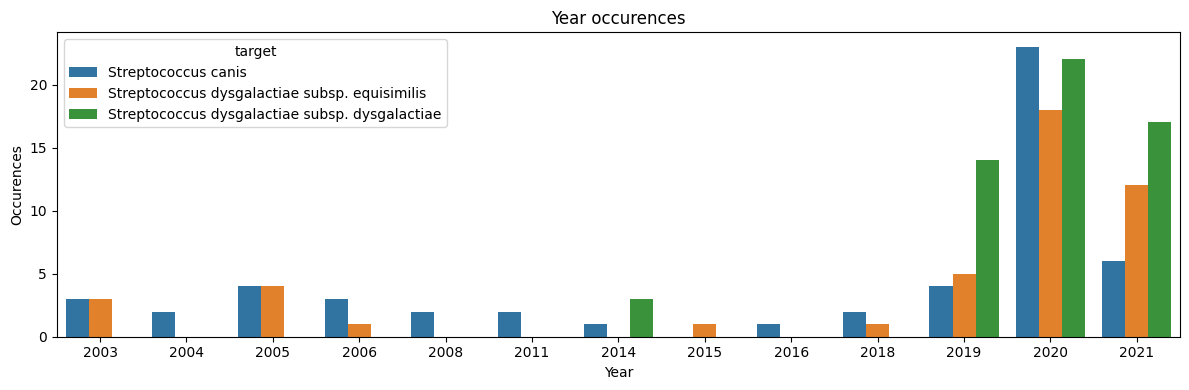

In [27]:
plt.figure(figsize=(12,4))
plt.title(label="Year occurences")
sns.countplot(x="Year", data=metadati, hue='target')
plt.ylabel("Occurences")
plt.tight_layout()
plt.show()

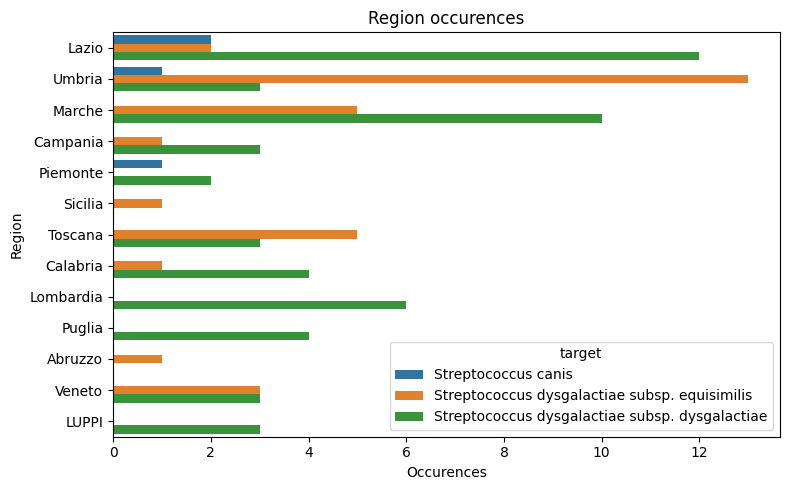

In [28]:
plt.figure(figsize=(8,5))
plt.title(label="Region occurences")
sns.countplot(y="Region", data=metadati, hue='target')
plt.xlabel("Occurences")
plt.tight_layout()
plt.show()

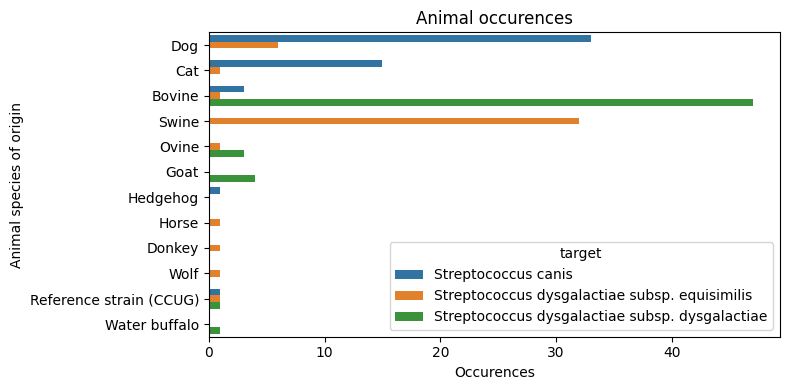

In [29]:
plt.figure(figsize=(8,4))
plt.title(label="Animal occurences")
sns.countplot(y="Animal species of origin", data=metadati, hue='target')
plt.xlabel("Occurences")
plt.tight_layout()
plt.show()

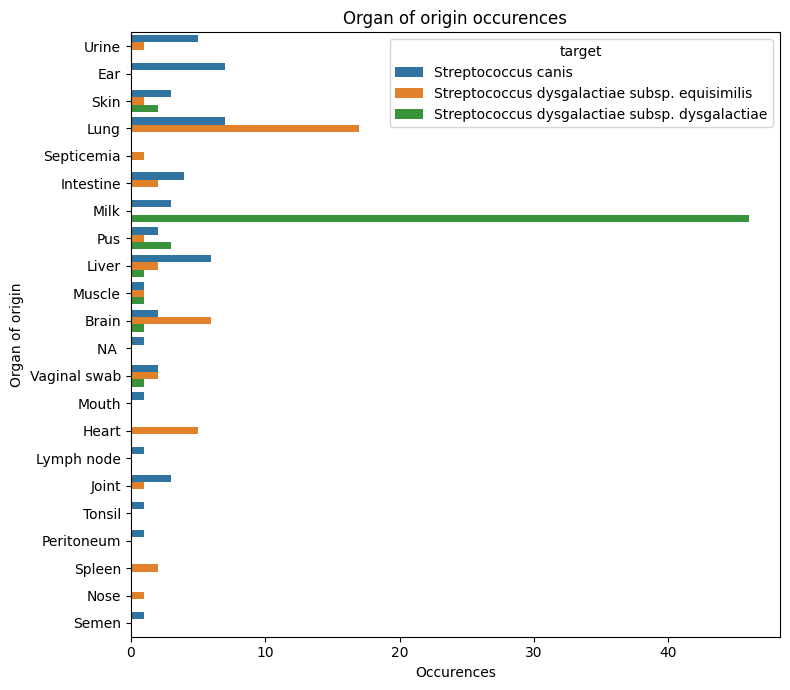

In [30]:
plt.figure(figsize=(8,7))
plt.title(label="Organ of origin occurences")
sns.countplot(y="Organ of origin", data=metadati, hue='target')
plt.xlabel("Occurences")
plt.tight_layout()
plt.show()

In [31]:
#One-Hot encode delle variabili categoriche
metadati_X = ['Animal species of origin','Organ of origin']

ct_meta = ColumnTransformer(transformers=[
    ("OneHot", OneHotEncoder(drop="if_binary", sparse=False, dtype=int), metadati_X)
])
#,remainder="passthrough"
metadati_arr = ct_meta.fit_transform(X=metadati.drop(columns='target'))
metadati_enc = pd.DataFrame(data=metadati_arr, columns=ct_meta.get_feature_names_out())
metadati_enc

,OneHot__Animal species of origin_Bovine,OneHot__Animal species of origin_Cat,OneHot__Animal species of origin_Dog,OneHot__Animal species of origin_Donkey,OneHot__Animal species of origin_Goat,OneHot__Animal species of origin_Hedgehog,OneHot__Animal species of origin_Horse,OneHot__Animal species of origin_Ovine,OneHot__Animal species of origin_Reference strain (CCUG),OneHot__Animal species of origin_Swine,...,OneHot__Organ of origin_Peritoneum,OneHot__Organ of origin_Pus,OneHot__Organ of origin_Semen,OneHot__Organ of origin_Septicemia,OneHot__Organ of origin_Skin,OneHot__Organ of origin_Spleen,OneHot__Organ of origin_Tonsil,OneHot__Organ of origin_Urine,OneHot__Organ of origin_Vaginal swab,OneHot__Organ of origin_nan
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
150,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
151,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
152,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
X_train, X_test, y_train, y_test = train_test_split(metadati_enc, df['Putative Subspecies'], test_size=0.2, random_state=42, stratify=df['Putative Subspecies'])

In [ ]:
models = [
    ("Model", LogisticRegression()),
    ("Model", DecisionTreeClassifier()),
    ("Model", KNeighborsClassifier()),
    ("Model", RandomForestClassifier())
]

for model in models:
    model = 

Accuracy of logistic regression classifier on test set: 0.871


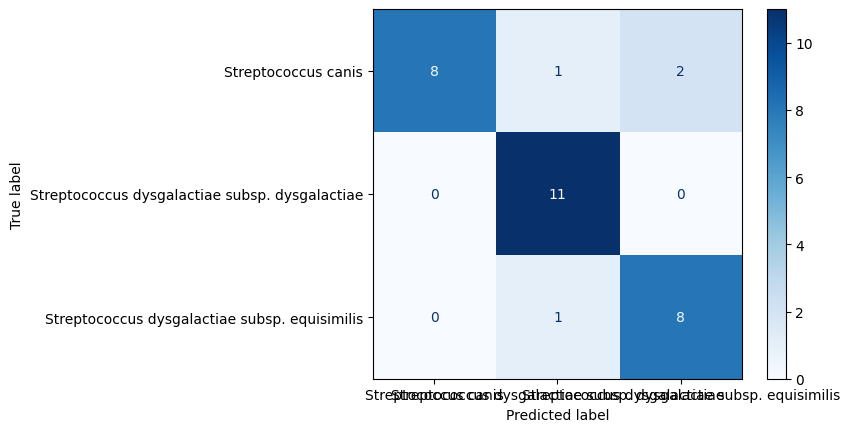

In [33]:
logr_md = LogisticRegression()
logr_md.fit(X=X_train,y=y_train)
y_pred = logr_md.predict(X_test)
accuracy_logic_md = logr_md.score(X_test, y_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(accuracy_logic_md))
ConfusionMatrixDisplay.from_estimator(estimator=logr_md, X=X_test, y=y_test, cmap='Blues')

In [34]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
base_cv_scores = cross_val_score(estimator=logr_md, X=X_train, y=y_train, 
                                scoring='accuracy', cv=skfold, n_jobs=-1, verbose=1)
base_cv_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


array([1.        , 0.84615385, 0.92307692, 0.91666667, 1.        ,
       0.75      , 0.83333333, 0.83333333, 0.91666667, 0.83333333])

In [35]:
dtc_md = DecisionTreeClassifier(random_state=42)
dtc_md = dtc_md.fit(X=X_train, y=y_train)
dtc_md

DecisionTreeClassifier(random_state=42)

In [36]:
dtc_md.get_depth()

15

In [37]:
feature_importances = dtc_md.feature_importances_
feature_index = metadati_enc.columns
myDict = dict(zip(feature_index, feature_importances))
myDict = dict(sorted(myDict.items(), key=lambda item: item[1], reverse = True))
myDict

{'OneHot__Animal species of origin_Bovine': 0.39170540632243556,
 'OneHot__Animal species of origin_Swine': 0.2653421036948222,
 'OneHot__Animal species of origin_Goat': 0.07186058789331733,
 'OneHot__Animal species of origin_Ovine': 0.056343068741111266,
 'OneHot__Organ of origin_Heart': 0.0349966697634895,
 'OneHot__Animal species of origin_Reference strain (CCUG)': 0.02724937933009218,
 'OneHot__Organ of origin_Vaginal swab': 0.02629589870744896,
 'OneHot__Organ of origin_Milk': 0.02369218050230325,
 'OneHot__Animal species of origin_Donkey': 0.021709524910946357,
 'OneHot__Animal species of origin_Horse': 0.02078571534026788,
 'OneHot__Organ of origin_Septicemia': 0.019919643867756694,
 'OneHot__Animal species of origin_Dog': 0.01404334892676846,
 'OneHot__Organ of origin_Pus': 0.008890492214620883,
 'OneHot__Organ of origin_Intestine': 0.0060791253687498,
 'OneHot__Animal species of origin_Cat': 0.004681116308922819,
 'OneHot__Organ of origin_Urine': 0.003775093797518384,
 'OneHot

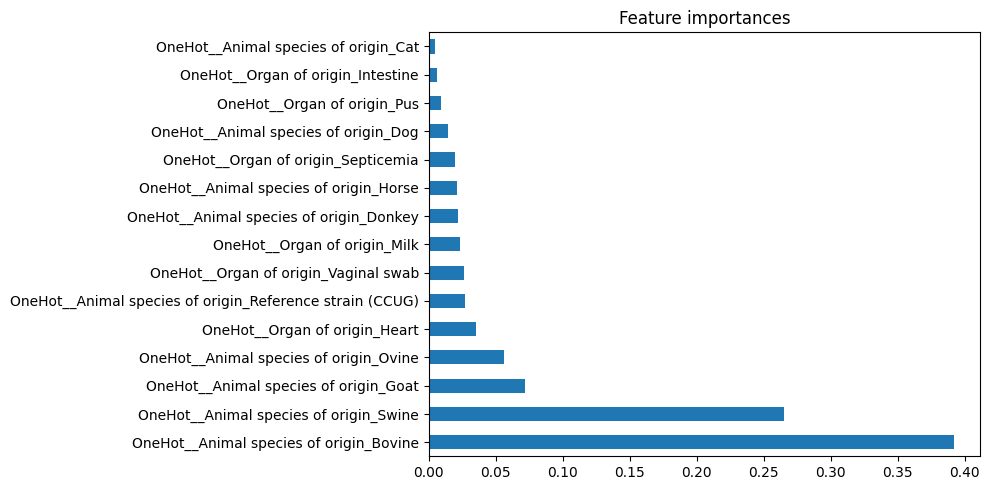

In [38]:
series = pd.Series(data=myDict.values(), index=myDict.keys()).head(15)
series.plot(kind="barh", figsize=(10, 5), title=f"Feature importances", legend=None)
plt.tight_layout()
plt.show()

In [39]:
y_pred = dtc_md.predict(X=X_test)
accuracy_albero_md = accuracy_score(y_true=y_test, y_pred=y_pred)
print('Accuracy of decision tree classifier with metadati on test set: {:.3f}'.format(accuracy_albero_md))

Accuracy of decision tree classifier with metadati on test set: 0.871


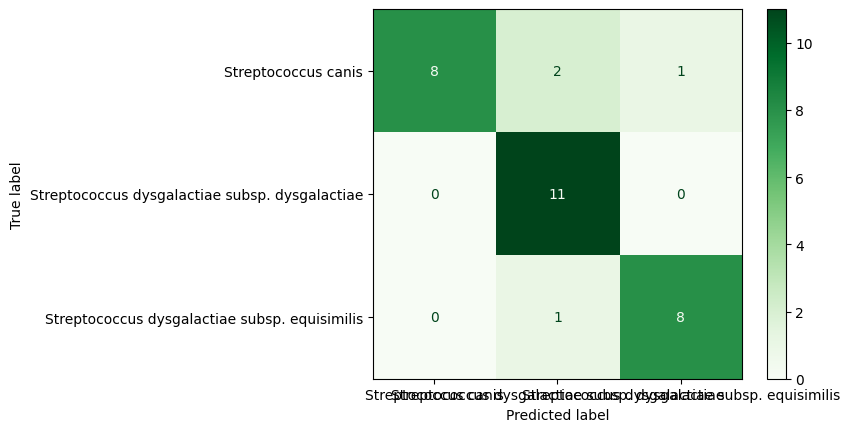

In [40]:
ConfusionMatrixDisplay.from_estimator(estimator=dtc_md, X=X_test, y=y_test, cmap='Greens')

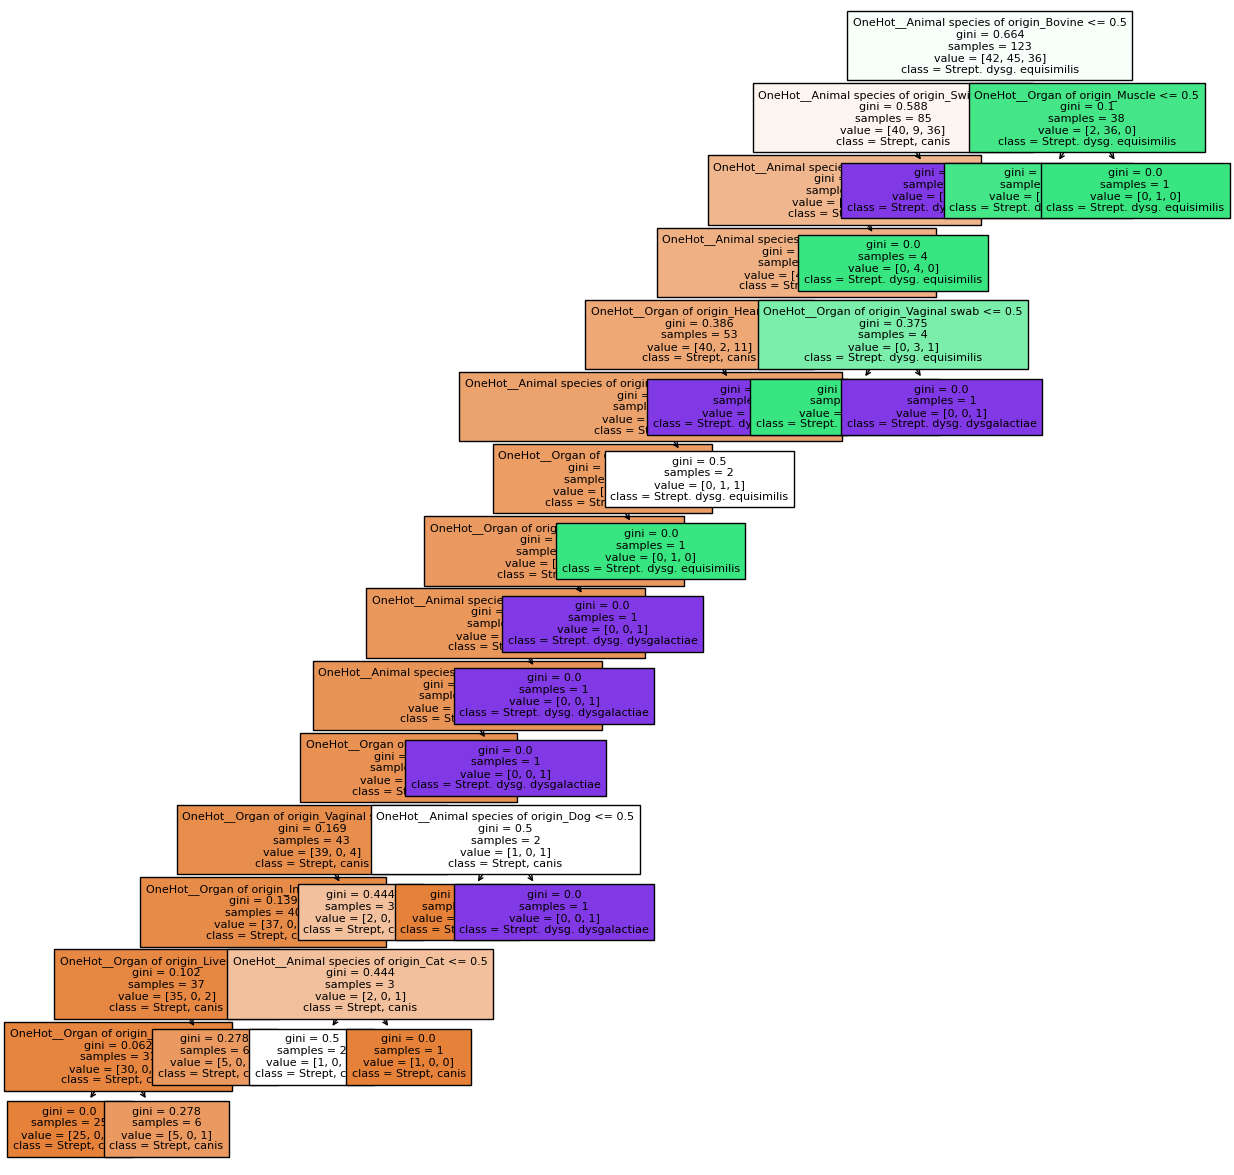

In [41]:
feature_names = feature_index
class_names = ["Strept, canis","Strept. dysg. equisimilis", "Strept. dysg. dysgalactiae"]

plt.figure(figsize=(15, 15))
plot_tree(decision_tree=dtc_md, 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, fontsize=8)
plt.show()

In [42]:

metadati_X = ['Animal species of origin','Organ of origin']
lor_reg_pipeline = Pipeline(steps=[
    ("OneHot", OneHotEncoder(drop="if_binary", sparse=False, dtype=int), metadati_X),
    ("Model", LogisticRegression(random_state=42))
])
results = cross_validate(log_reg_pipeline,X_train,y_train)

NameError: name 'cross_validate' is not defined

In [ ]:
#TO DO:Modelli con colonne metadati codificate

# Analisi Principali

In [ ]:
principali.dtypes

ST                     object
Species                object
Putative Subspecies    object
LANCEFIELD GROUP       object
Haemolysis             object
dtype: object

In [ ]:
principali

,ST,Species,Putative Subspecies,LANCEFIELD GROUP,Haemolysis
ID Strain,,,,,
V13,ST13,Streptococcus_canis,Streptococcus canis,G,b
V142,ST23,Streptococcus_canis,Streptococcus canis,G,b
V151,ST95,Streptococcus_canis,Streptococcus canis,G,b
V160,ST15,Streptococcus_canis,Streptococcus canis,G,b
V161,ST9,Streptococcus_canis,Streptococcus canis,G,b
...,...,...,...,...,...
V800,ST307,Streptococcus_dysgalactiae,Streptococcus dysgalactiae subsp. dysgalactiae,C,a
V82,ST9,Streptococcus_canis,Streptococcus canis,G,b
V90,ST13,Streptococcus_canis,Streptococcus canis,G,b


In [ ]:
principali.isnull().sum()

ST                     0
Species                0
Putative Subspecies    0
LANCEFIELD GROUP       0
Haemolysis             0
dtype: int64

<AxesSubplot: xlabel='Count', ylabel='Putative Subspecies'>

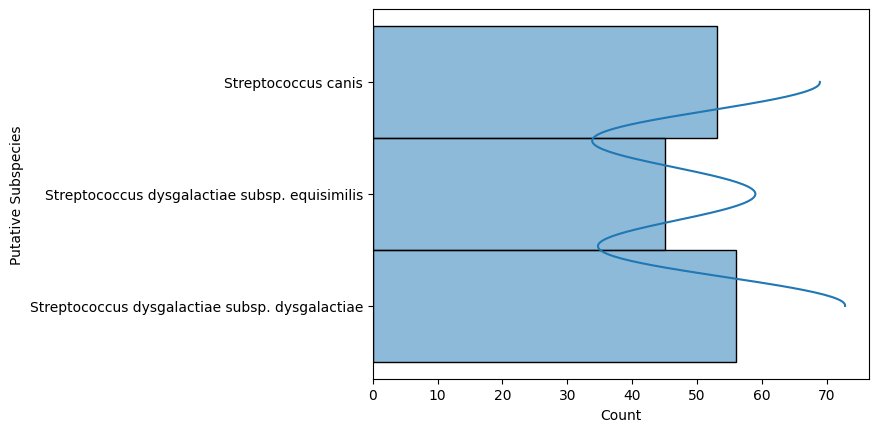

In [ ]:
sns.histplot(data=principali, y="Putative Subspecies", kde=True)

In [ ]:
#sns.countplot(y="Putative Subspecies", data=principali)

<AxesSubplot: xlabel='count', ylabel='Species'>

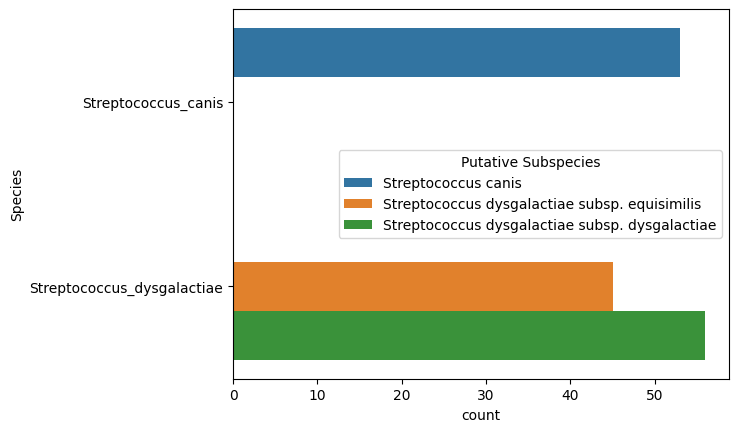

In [ ]:
sns.countplot(y="Species", data=principali, hue="Putative Subspecies")

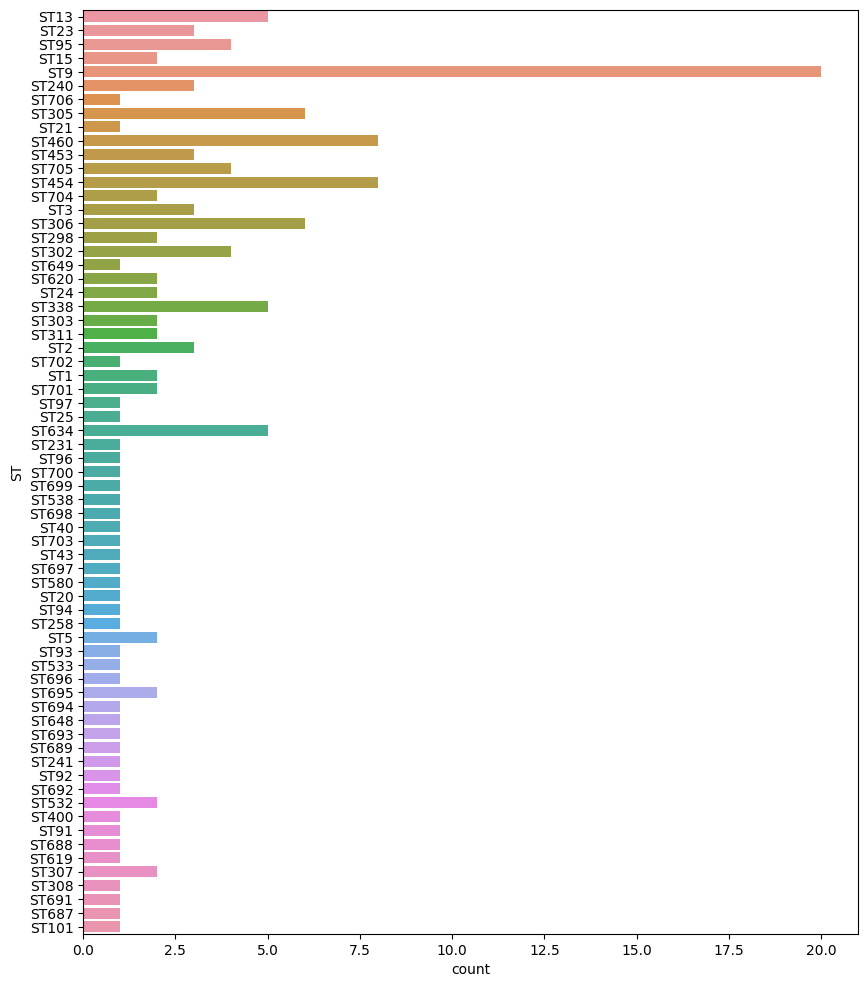

In [ ]:
fig = plt.figure(figsize=(10, 12))
sns.countplot(y="ST", data=principali)
plt.show()

<AxesSubplot: xlabel='count', ylabel='LANCEFIELD GROUP'>

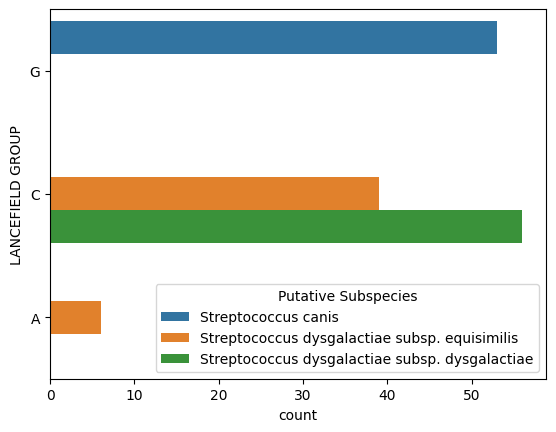

In [ ]:
sns.countplot(y="LANCEFIELD GROUP", data=principali, hue="Putative Subspecies")

<AxesSubplot: xlabel='count', ylabel='Haemolysis'>

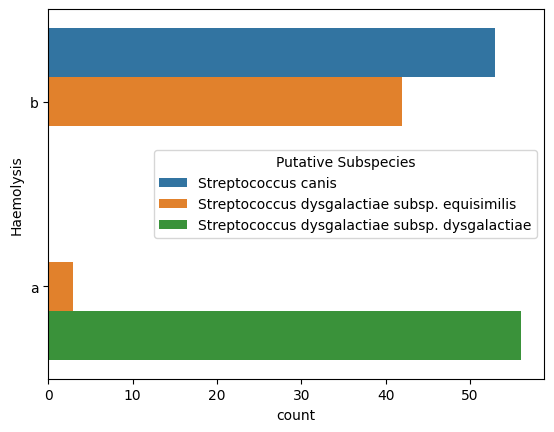

In [ ]:
principali = principali.replace('b ','b')
sns.countplot(y="Haemolysis", data=principali, hue="Putative Subspecies")

In [ ]:
principali["Species"].unique()

array(['Streptococcus_canis', 'Streptococcus_dysgalactiae'], dtype=object)

In [ ]:
principali_X = ["Species", "Haemolysis", "LANCEFIELD GROUP"]
ct_princ = ColumnTransformer(transformers=[
    ("OneHot", OneHotEncoder(drop="if_binary", sparse=False, dtype=int), principali_X)
],remainder="passthrough")

principali_arr = ct_princ.fit_transform(X=principali[principali_X])
principali_enc = pd.DataFrame(data=principali_arr, columns=ct_princ.get_feature_names_out())
principali_enc

,OneHot__Species_Streptococcus_dysgalactiae,OneHot__Haemolysis_a,OneHot__Haemolysis_b,OneHot__Haemolysis_b,OneHot__LANCEFIELD GROUP_A,OneHot__LANCEFIELD GROUP_C,OneHot__LANCEFIELD GROUP_G
0,0,0,1,0,0,0,1
1,0,0,1,0,0,0,1
2,0,0,1,0,0,0,1
3,0,0,1,0,0,0,1
4,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...
149,1,1,0,0,0,1,0
150,0,0,1,0,0,0,1
151,0,0,1,0,0,0,1
152,0,0,1,0,0,0,1


# Analisi Picchi Maldi

In [ ]:
maldi

,"2057,143278","2064,798679","2071,138797","2085,647901","2103,986922","2117,879078","2129,309534","2143,905333","2173,98153","2188,116404",...,"13617,65054","14104,26499","14945,23828","15048,68998","15154,39575","15353,52046","15399,07159","15495,16655","16076,29338","16202,09535"
ID Strain,,,,,,,,,,,,,,,,,,,,,
V13,"7,98659E-05",NaN,NaN,NaN,"8,6366E-05",NaN,"5,18954E-05","4,71446E-05","6,79758E-05","4,98065E-05",...,NaN,NaN,"6,6474E-05","0,000142108",NaN,NaN,NaN,NaN,NaN,NaN
V142,NaN,NaN,"4,95094E-05","4,4623E-05","7,7739E-05",NaN,"4,71991E-05",NaN,"9,10179E-05",NaN,...,NaN,NaN,"8,50988E-05","0,000194467",NaN,NaN,NaN,NaN,NaN,NaN
V151,NaN,NaN,"6,02675E-05","4,77862E-05","0,000100212",NaN,NaN,"4,66259E-05","5,38334E-05","5,36443E-05",...,NaN,NaN,"9,21027E-05","6,97349E-05",NaN,NaN,NaN,NaN,NaN,NaN
V160,NaN,NaN,"6,55556E-05",NaN,"8,85014E-05",NaN,"5,06035E-05",NaN,"6,73724E-05",NaN,...,NaN,NaN,"9,8051E-05","0,000135981",NaN,NaN,NaN,NaN,NaN,NaN
V161,NaN,NaN,NaN,NaN,"7,72199E-05",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"8,86343E-05","0,000203245",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,"5,54677E-05",NaN,NaN,"6,04758E-05","0,000104711",NaN,NaN,NaN,"0,000117229",NaN,...,NaN,"3,59969E-05","7,29765E-05","5,96036E-05",NaN,NaN,NaN,NaN,NaN,NaN
V82,"4,27382E-05",NaN,NaN,NaN,"6,63897E-05",NaN,NaN,NaN,"5,30903E-05","4,95847E-05",...,NaN,NaN,"8,98385E-05","0,000143522",NaN,NaN,NaN,NaN,NaN,NaN
V90,NaN,NaN,"5,06192E-05",NaN,"8,87478E-05",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"0,000103564","0,000137316",NaN,NaN,"5,13985E-05",NaN,NaN,NaN


In [ ]:
maldi.isnull().sum().sort_values(ascending=False).head(20)

5780,539599    140
6587,606933    139
2423,645677    138
2535,074449    138
6814,418663    138
5283,615576    138
3406,307673    138
5114,565557    138
2392,41521     138
4877,931808    138
9652,709405    138
2249,262227    137
15353,52046    137
5296,883734    136
6861,319414    136
2490,961213    136
5639,896531    136
3061,280788    136
4142,664282    136
15495,16655    136
dtype: int64

In [ ]:
#sostituisco tutti i NaN con 0
maldi.fillna(0,inplace=True)

##### Preparazione dati maldi

In [ ]:
maldi = maldi.replace(',', '.', regex=True)
maldi

,"2057,143278","2064,798679","2071,138797","2085,647901","2103,986922","2117,879078","2129,309534","2143,905333","2173,98153","2188,116404",...,"13617,65054","14104,26499","14945,23828","15048,68998","15154,39575","15353,52046","15399,07159","15495,16655","16076,29338","16202,09535"
ID Strain,,,,,,,,,,,,,,,,,,,,,
V13,7.98659E-05,0,0,0,8.6366E-05,0,5.18954E-05,4.71446E-05,6.79758E-05,4.98065E-05,...,0,0,6.6474E-05,0.000142108,0,0,0,0,0,0
V142,0,0,4.95094E-05,4.4623E-05,7.7739E-05,0,4.71991E-05,0,9.10179E-05,0,...,0,0,8.50988E-05,0.000194467,0,0,0,0,0,0
V151,0,0,6.02675E-05,4.77862E-05,0.000100212,0,0,4.66259E-05,5.38334E-05,5.36443E-05,...,0,0,9.21027E-05,6.97349E-05,0,0,0,0,0,0
V160,0,0,6.55556E-05,0,8.85014E-05,0,5.06035E-05,0,6.73724E-05,0,...,0,0,9.8051E-05,0.000135981,0,0,0,0,0,0
V161,0,0,0,0,7.72199E-05,0,0,0,0,0,...,0,0,8.86343E-05,0.000203245,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,5.54677E-05,0,0,6.04758E-05,0.000104711,0,0,0,0.000117229,0,...,0,3.59969E-05,7.29765E-05,5.96036E-05,0,0,0,0,0,0
V82,4.27382E-05,0,0,0,6.63897E-05,0,0,0,5.30903E-05,4.95847E-05,...,0,0,8.98385E-05,0.000143522,0,0,0,0,0,0
V90,0,0,5.06192E-05,0,8.87478E-05,0,0,0,0,0,...,0,0,0.000103564,0.000137316,0,0,5.13985E-05,0,0,0


In [ ]:
columns = maldi.columns
for column in columns:
    maldi[column] = maldi[column].astype(float)
maldi

,"2057,143278","2064,798679","2071,138797","2085,647901","2103,986922","2117,879078","2129,309534","2143,905333","2173,98153","2188,116404",...,"13617,65054","14104,26499","14945,23828","15048,68998","15154,39575","15353,52046","15399,07159","15495,16655","16076,29338","16202,09535"
ID Strain,,,,,,,,,,,,,,,,,,,,,
V13,0.000080,0.0,0.000000,0.000000,0.000086,0.000000,0.000052,0.000047,0.000068,0.000050,...,0.0,0.000000,0.000066,0.000142,0.0,0.0,0.000000,0.0,0.0,0.0
V142,0.000000,0.0,0.000050,0.000045,0.000078,0.000000,0.000047,0.000000,0.000091,0.000000,...,0.0,0.000000,0.000085,0.000194,0.0,0.0,0.000000,0.0,0.0,0.0
V151,0.000000,0.0,0.000060,0.000048,0.000100,0.000000,0.000000,0.000047,0.000054,0.000054,...,0.0,0.000000,0.000092,0.000070,0.0,0.0,0.000000,0.0,0.0,0.0
V160,0.000000,0.0,0.000066,0.000000,0.000089,0.000000,0.000051,0.000000,0.000067,0.000000,...,0.0,0.000000,0.000098,0.000136,0.0,0.0,0.000000,0.0,0.0,0.0
V161,0.000000,0.0,0.000000,0.000000,0.000077,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000089,0.000203,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,0.000055,0.0,0.000000,0.000060,0.000105,0.000000,0.000000,0.000000,0.000117,0.000000,...,0.0,0.000036,0.000073,0.000060,0.0,0.0,0.000000,0.0,0.0,0.0
V82,0.000043,0.0,0.000000,0.000000,0.000066,0.000000,0.000000,0.000000,0.000053,0.000050,...,0.0,0.000000,0.000090,0.000144,0.0,0.0,0.000000,0.0,0.0,0.0
V90,0.000000,0.0,0.000051,0.000000,0.000089,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000104,0.000137,0.0,0.0,0.000051,0.0,0.0,0.0


In [ ]:
map_target = {
    "Streptococcus canis" : 0,
    "Streptococcus dysgalactiae subsp. equisimilis" : 1,
    "Streptococcus dysgalactiae subsp. dysgalactiae" : 2  
}
maldi['target'] = principali["Putative Subspecies"].map(map_target)
#sns.pairplot(data=maldi, hue='target')
maldi[['target']].sample(10)

,target
ID Strain,
V13,0
V286,2
V300,1
V190,2
V576,2
V573,2
V581,2
V597,1
V186,0


#### Ricerca correllazioni più alte con variabile target 

In [ ]:
corr = maldi.corr()
corr

,"2057,143278","2064,798679","2071,138797","2085,647901","2103,986922","2117,879078","2129,309534","2143,905333","2173,98153","2188,116404",...,"14104,26499","14945,23828","15048,68998","15154,39575","15353,52046","15399,07159","15495,16655","16076,29338","16202,09535",target
"2057,143278",1.000000,-0.068457,-0.066517,0.493853,0.380472,-0.031394,0.185633,0.240985,0.473723,0.384678,...,-0.053156,-0.246925,0.113149,0.119611,0.219807,-0.236770,0.326854,-0.045185,-0.087578,-0.077452
"2064,798679",-0.068457,1.000000,-0.006892,0.068057,-0.042973,-0.041741,-0.034696,-0.037146,0.057989,-0.047709,...,-0.044438,0.030154,0.010930,0.104194,-0.026248,-0.041066,-0.029159,-0.040067,-0.044287,-0.001285
"2071,138797",-0.066517,-0.006892,1.000000,-0.065008,0.051752,-0.041721,-0.033553,-0.036940,-0.008164,-0.046862,...,0.202014,0.177975,0.047723,-0.034155,-0.026192,0.264887,-0.028286,-0.040026,-0.044241,-0.099858
"2085,647901",0.493853,0.068057,-0.065008,1.000000,0.349521,0.151131,0.036334,0.153132,0.401137,0.149272,...,0.041255,0.056237,-0.227843,-0.040405,-0.016386,-0.168047,0.023956,-0.256025,-0.289394,0.219587
"2103,986922",0.380472,-0.042973,0.051752,0.349521,1.000000,0.068998,0.238401,0.147754,0.650993,0.208672,...,0.009707,0.054503,-0.095421,-0.087589,0.036960,-0.111735,0.070743,-0.304763,-0.343140,-0.076477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"15399,07159",-0.236770,-0.041066,0.264887,-0.168047,-0.111735,0.010620,-0.166991,-0.145347,-0.184978,-0.184012,...,0.532930,0.410916,-0.134925,-0.082834,0.009880,1.000000,-0.182203,-0.155846,-0.000985,0.233494
"15495,16655",0.326854,-0.029159,-0.028286,0.023956,0.070743,-0.182219,-0.150355,-0.134466,0.029475,0.036742,...,-0.192708,-0.551438,0.661583,0.453883,0.449534,-0.182203,1.000000,0.334343,0.225451,-0.365778
"16076,29338",-0.045185,-0.040067,-0.040026,-0.256025,-0.304763,-0.251805,-0.207773,-0.183429,-0.139203,-0.128798,...,-0.197435,-0.528830,0.806979,0.323733,0.174298,-0.155846,0.334343,1.000000,0.863215,-0.373514
"16202,09535",-0.087578,-0.044287,-0.044241,-0.289394,-0.343140,-0.180800,-0.228891,-0.214990,-0.204771,-0.187413,...,-0.021207,-0.384607,0.652187,0.214881,0.083882,-0.000985,0.225451,0.863215,1.000000,-0.224832


In [ ]:
corr = corr.sort_values('target')
top_corr_inv = corr[0:5]
top_corr = corr[-6:-1]
print(top_corr[['target']])
print(top_corr_inv[['target']])

               target
6731,019005  0.832741
6312,28957   0.834384
9829,326089  0.841308
6891,554249  0.844212
3364,797303  0.854254
               target
6327,306693 -0.875539
6710,334937 -0.745410
5522,688276 -0.710834
3762,662684 -0.703397
3354,28405  -0.695326


#### Pairplot 10 best correlation score

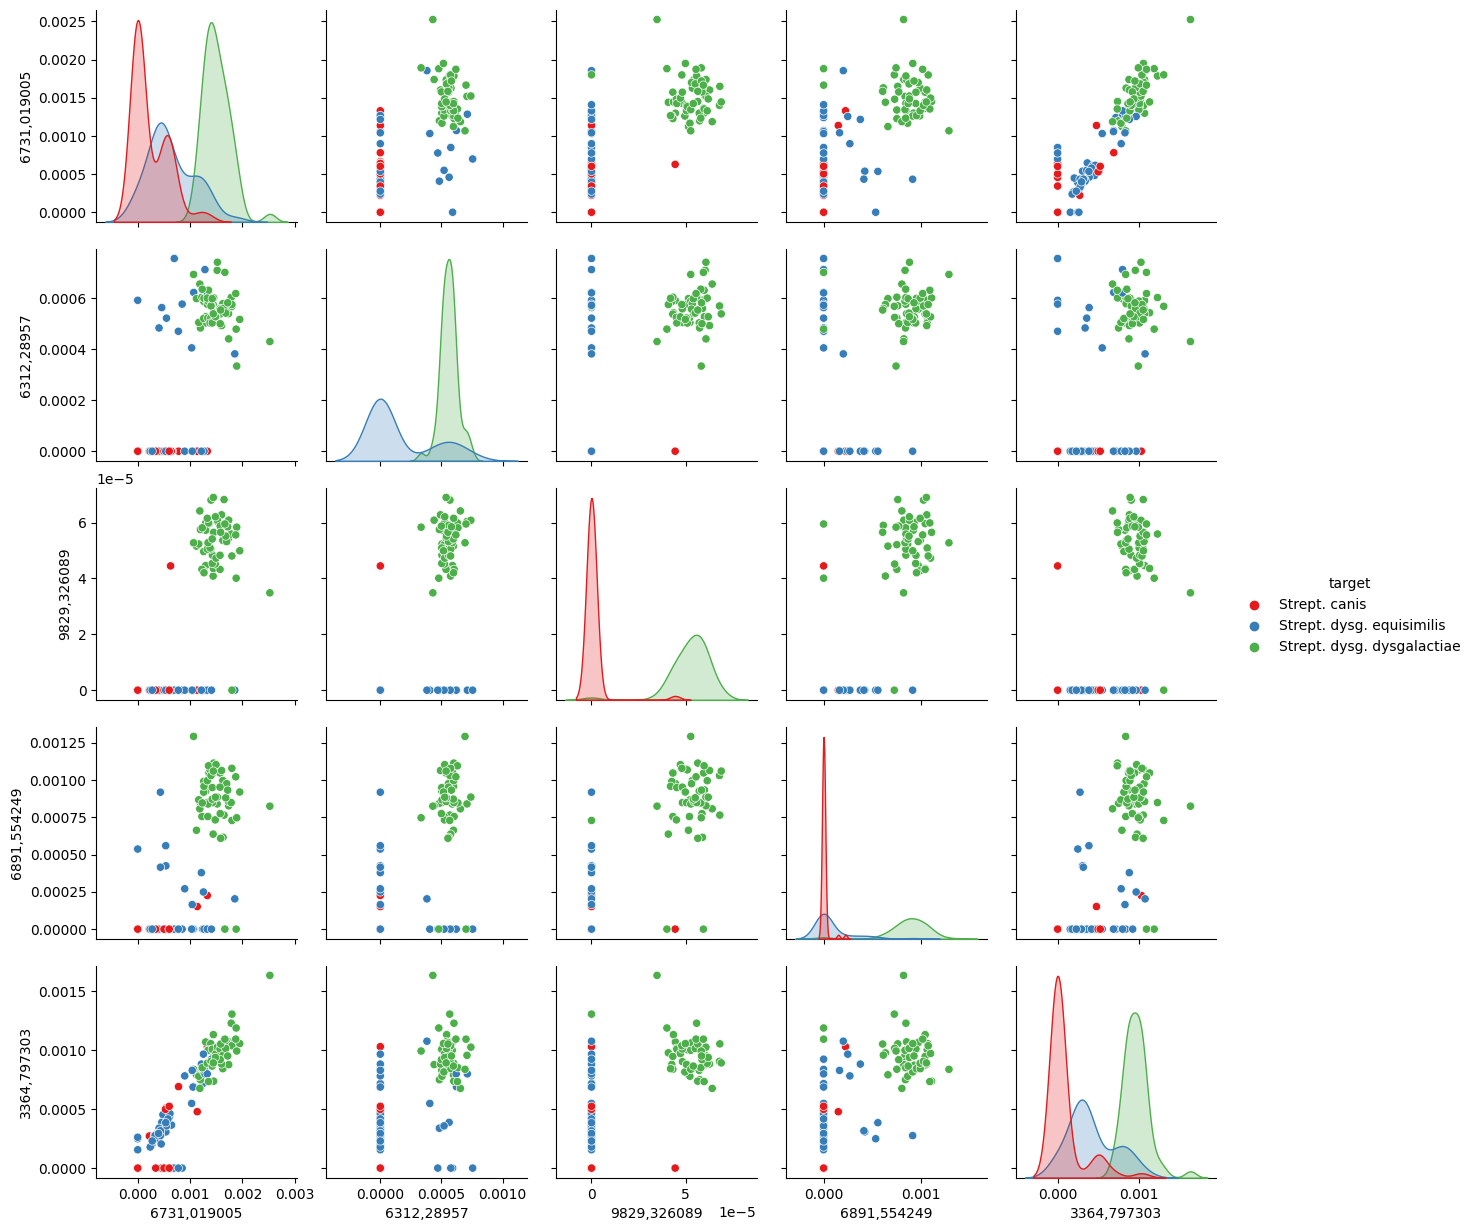

In [ ]:
map_target_to_name = {
    0 : "Strept. canis",
    1 : "Strept. dysg. equisimilis",
    2 : "Strept. dysg. dysgalactiae"  
}
pairplot = maldi[top_corr.index.to_series()]
pairplot['target'] = maldi['target'].map(map_target_to_name)

sns.pairplot(data=pairplot, hue="target", palette=sns.color_palette('Set1'))
plt.show()

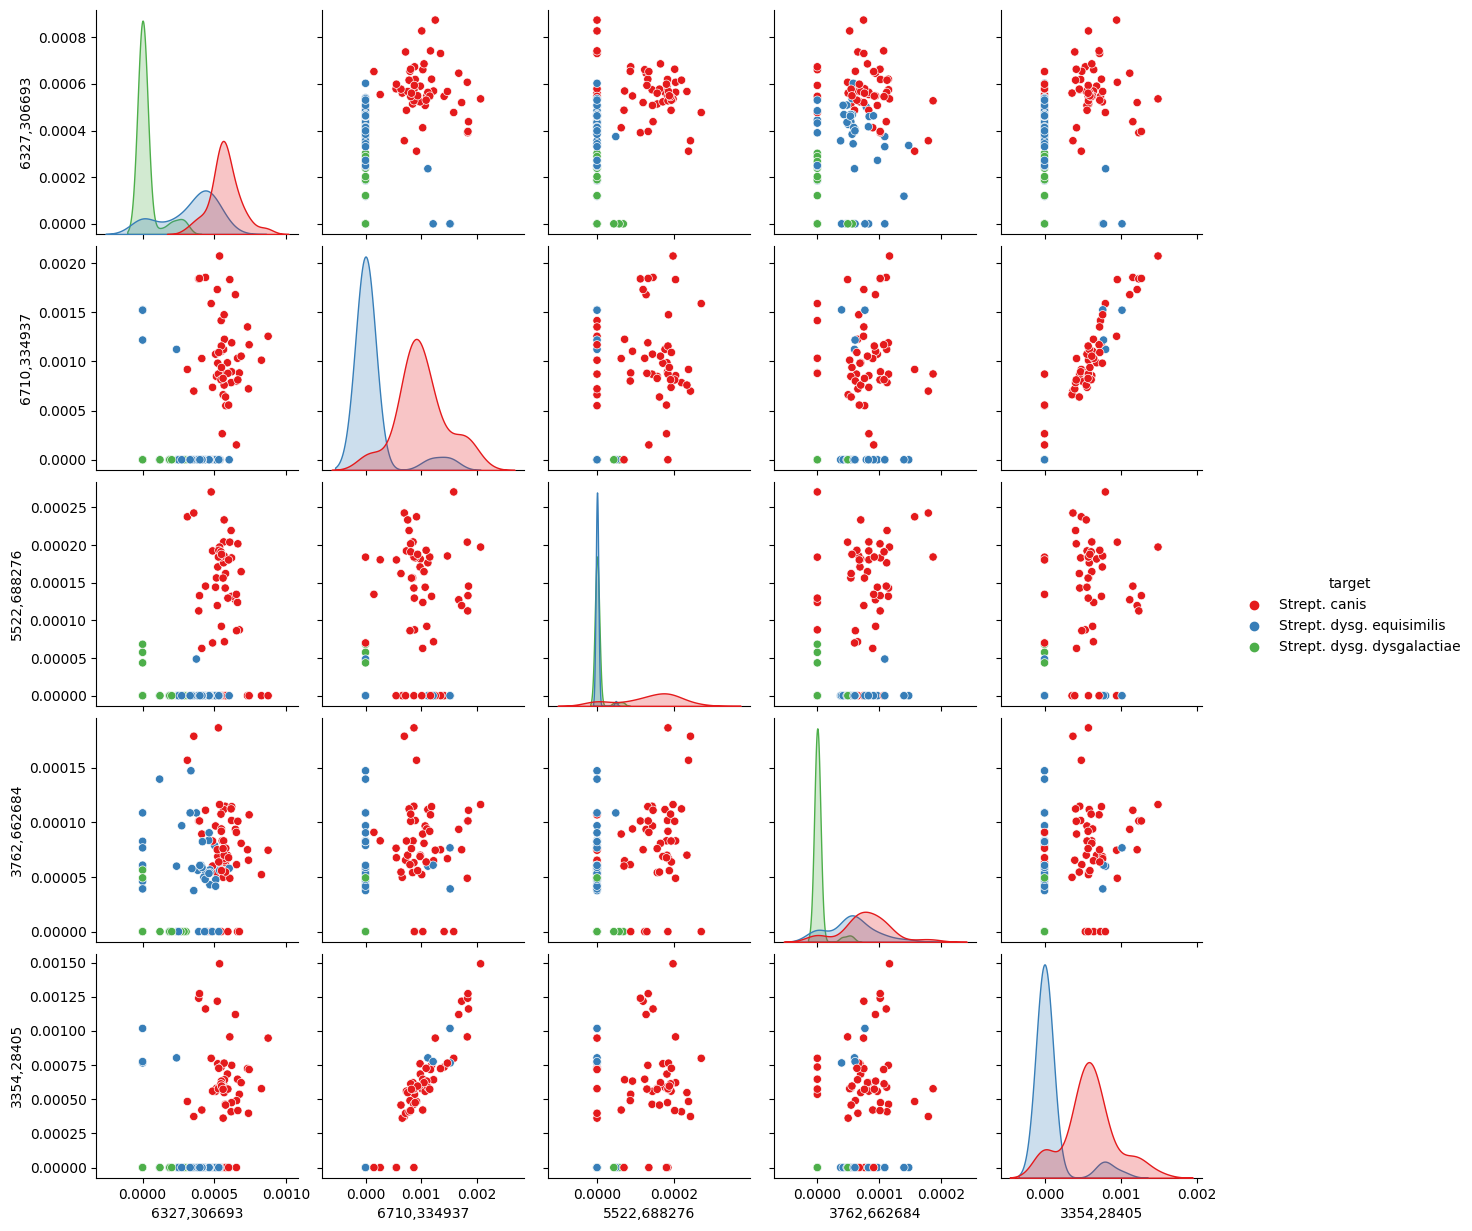

In [ ]:
pairplot = maldi[top_corr_inv.index.to_series()]
pairplot['target'] = maldi['target'].map(map_target_to_name)
sns.pairplot(data=pairplot, hue="target", palette=sns.color_palette('Set1'))
plt.show()

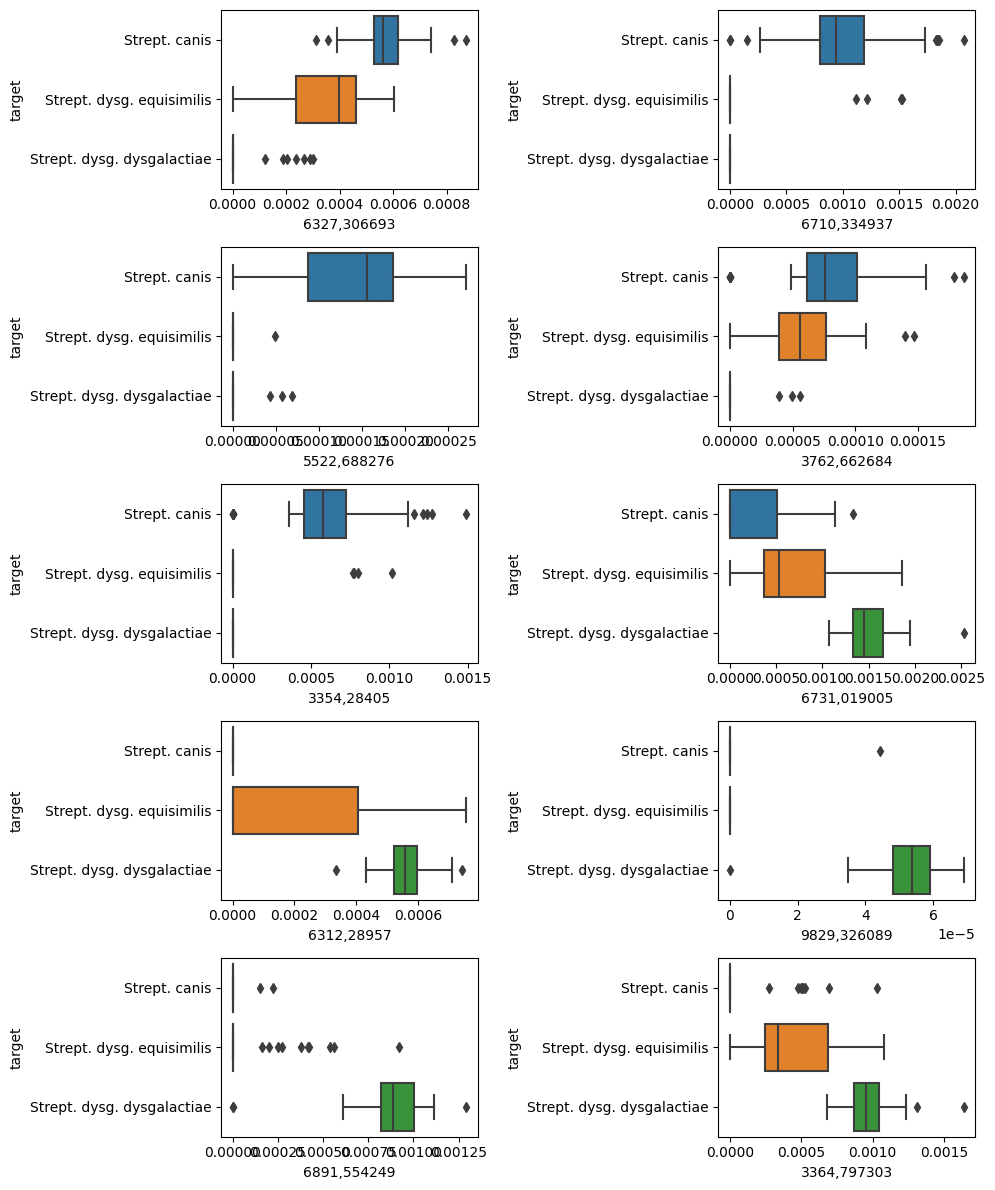

In [ ]:
s1 = top_corr_inv.index
s2 = top_corr.index
boxplot_col = np.concatenate([s1, s2])
boxplot = maldi[boxplot_col]
boxplot['target'] = maldi['target'].map(map_target_to_name)
fig = plt.figure(figsize=(10, 12))
axes = fig.subplots(nrows=5, ncols=2)
for ax, column in zip(axes.flat, boxplot):
    sns.boxplot(y="target", x=column, data=boxplot, ax=ax)
plt.tight_layout()
plt.show()

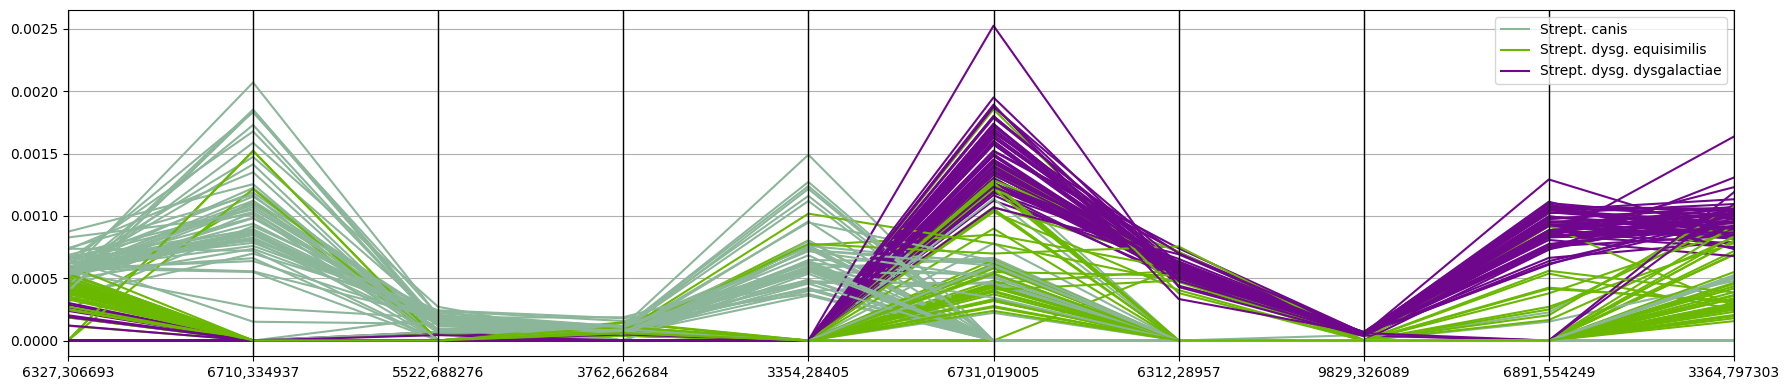

In [ ]:
fig = plt.figure(figsize=(18, 4))
ax = fig.subplots()
parallel_coordinates(boxplot, class_column="target", ax=ax)
plt.tight_layout()
fig.show()

### Training con 10 feature con correlazione più alta

In [ ]:
index = pd.concat([top_corr.index.to_series(),top_corr_inv.index.to_series()])
X = maldi[index]
y = maldi['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(123, 10)
(123,)
(31, 10)
(31,)


In [ ]:
models = [
    ("Model", LogisticRegression()),
    ("Model", DecisionTreeClassifier()),
    ("Model", KNeighborsClassifier()),
    ("Model", RandomForestClassifier())
]

for model in models:
    pipeline = Pipeline(
        steps = [
            ("Scaler", StandardScaler()),
            model
        ]
    )
    pipeline.fit(X=X_train, y=y_train)

In [ ]:
#Scaling dati
ss = StandardScaler()

In [ ]:
X_train = ss.fit_transform(X=X_train)
X_test = ss.transform(X=X_test)

#### Logistic Regression with 10 best corr

In [ ]:
logr10 = LogisticRegression()
logr10.fit(X=X_train,y=y_train)

LogisticRegression()

In [ ]:
y_pred = logr10.predict(X_test)
accuracy_logic10 = logr10.score(X_test, y_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(accuracy_logic10))

Accuracy of logistic regression classifier on test set: 0.968


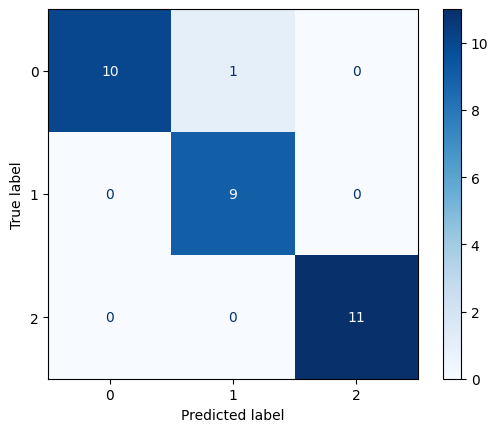

In [ ]:
ConfusionMatrixDisplay.from_estimator(estimator=logr10, X=X_test, y=y_test, cmap='Blues')

<font color= "red">Not work</font>

#### Decision tree with 10 best corr

In [ ]:
dtc10 = DecisionTreeClassifier(random_state=42)
dtc10 = dtc10.fit(X=X_train, y=y_train)
dtc10

DecisionTreeClassifier(random_state=42)

In [ ]:
dtc10.get_depth()

4

In [ ]:
feature_importances = dtc10.feature_importances_
feature_index = X.columns
myDict = dict(zip(feature_index, feature_importances))
myDict

{'6731,019005': 0.0,
 '6312,28957': 0.08926058675162617,
 '9829,326089': 0.0,
 '6891,554249': 0.4902893933359883,
 '3364,797303': 0.02372685185185185,
 '6327,306693': 0.0239479622992168,
 '6710,334937': 0.34974415601655745,
 '5522,688276': 0.023031049744759405,
 '3762,662684': 0.0,
 '3354,28405': 0.0}

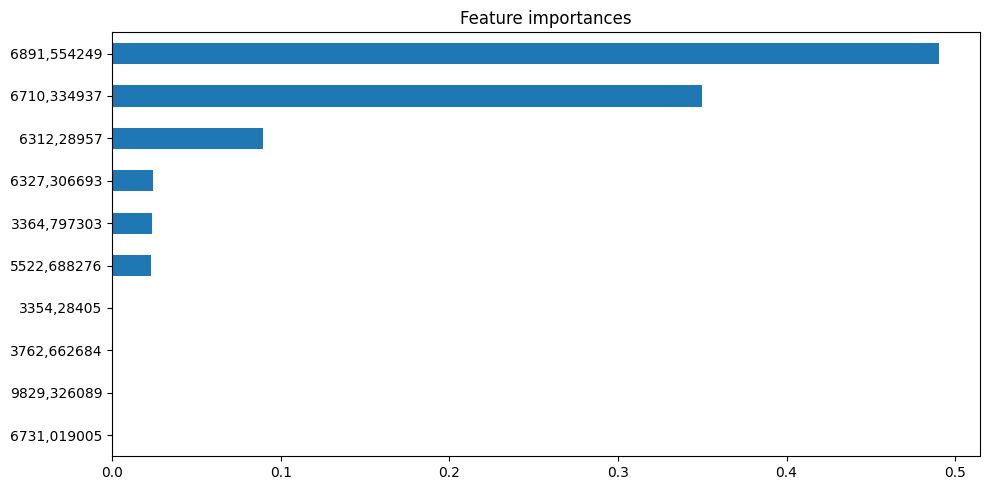

In [ ]:
series = pd.Series(data=myDict.values(), index=myDict.keys()).sort_values()
series.plot(kind="barh", figsize=(10, 5), title=f"Feature importances", legend=None)
plt.tight_layout()
plt.show()

In [ ]:
y_pred = dtc10.predict(X=X_test)
accuracy_albero10 = accuracy_score(y_true=y_test, y_pred=y_pred)
print('Accuracy of decision tree classifier on test set: {:.3f}'.format(accuracy_albero10))

Accuracy of decision tree classifier on test set: 0.968


In [ ]:
y_pred_train = dtc10.predict(X=X_train)
accuracy_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)
print(f"train accuracy score: {accuracy_train:.4f}")

train accuracy score: 1.0000


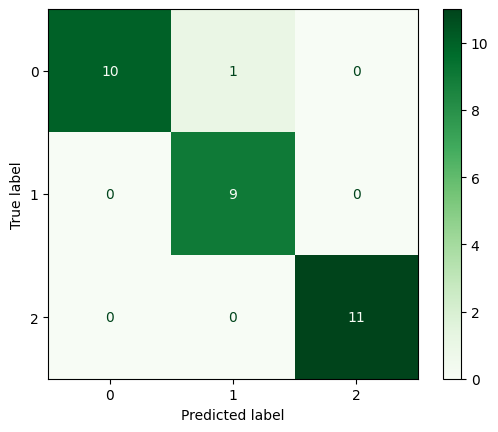

In [ ]:
ConfusionMatrixDisplay.from_estimator(estimator=dtc10, X=X_test, y=y_test, cmap='Greens')

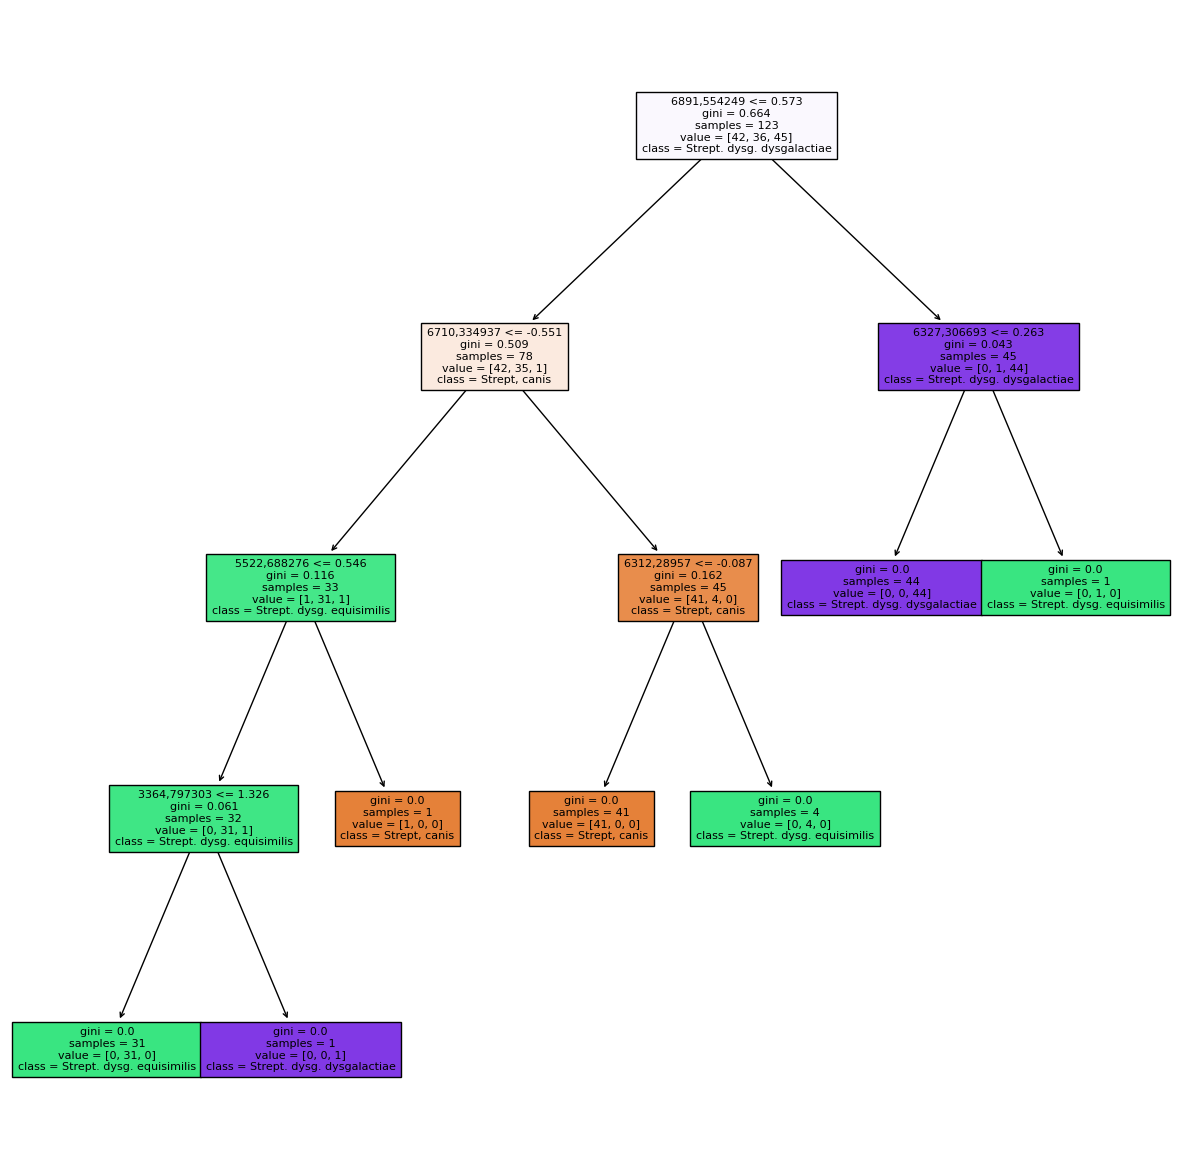

In [ ]:
feature_names = feature_index
class_names = ["Strept, canis","Strept. dysg. equisimilis", "Strept. dysg. dysgalactiae"]

plt.figure(figsize=(15, 15))
plot_tree(decision_tree=dtc10, 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, fontsize=8)
plt.show()

#### K-nn with 10 best scorr

In [ ]:
knn_scores = []

for k in range(1, X_train.shape[0], 2):
    # model definition and training
    knn = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=k))
    ])
    knn.fit(X=X_train, y=y_train)
    # compute accuracy on test set
    accuracy = knn.score(X_test, y_test)
    # store the results on a list of dictionaries
    metrics = {"# neighbors": k, "accuracy": accuracy}
    knn_scores.append(metrics)

# convert the list of dictionaries to pandas dataframe
df_knn_scores10 = pd.DataFrame(data=knn_scores)    #molto facile eveloce da dizionario a dataframe 
df_knn_scores10

,# neighbors,accuracy
0,1,0.967742
1,3,0.967742
2,5,0.967742
3,7,0.967742
4,9,0.967742
...,...,...
56,113,0.677419
57,115,0.677419
58,117,0.677419
59,119,0.677419


In [ ]:
mask = df_knn_scores10["accuracy"] == df_knn_scores10["accuracy"].max()   
df_knn_scores10[mask]

,# neighbors,accuracy
0,1,0.967742
1,3,0.967742
2,5,0.967742
3,7,0.967742
4,9,0.967742
5,11,0.967742
6,13,0.967742


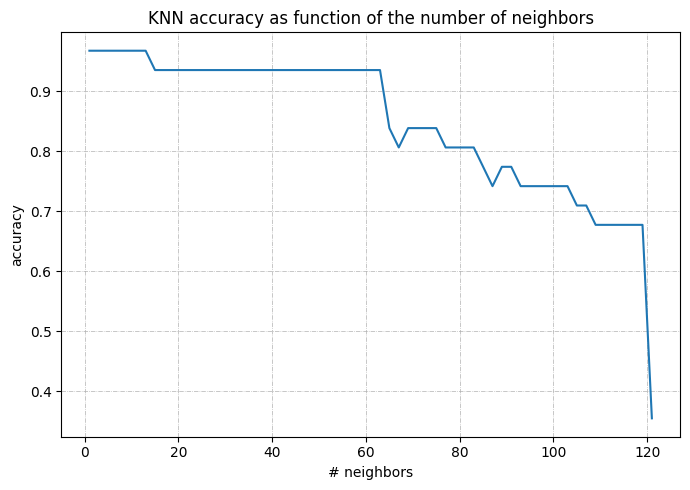

In [ ]:
plt.figure(figsize=(7, 5))
plt.title("KNN accuracy as function of the number of neighbors")
sns.lineplot(x="# neighbors", y="accuracy", data=df_knn_scores10)
plt.grid(linestyle='-.', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
knn_small = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=1))
])
knn_small.fit(X=X_train, y=y_train)
y_pred = knn_small.predict(X=X_test)
accuracy_knn10 = accuracy_score(y_true=y_test, y_pred=y_pred)
print('Accuracy of k-nn classifier on test set with k=1: {:.3f}'.format(accuracy_knn10))

Accuracy of k-nn classifier on test set with k=1: 0.968


In [ ]:
knn_big = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=37))
])
knn_big.fit(X=X_train, y=y_train)
y_pred = knn_big.predict(X=X_test)
accuracy_knn10_big = accuracy_score(y_true=y_test, y_pred=y_pred)
print('Accuracy of k-nn classifier on test set with k=37: {:.3f}'.format(accuracy_knn10_big))

Accuracy of k-nn classifier on test set with k=37: 0.935


<font color= "red">Not work</font>

#### Random Forest with 10 best scorr

In [ ]:
forest10 = RandomForestRegressor(n_estimators=200, 
                               max_features="sqrt", 
                               oob_score=True, 
                               random_state=42) # n_jobs=-1 per multithreading
forest10.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=200, oob_score=True,
                      random_state=42)

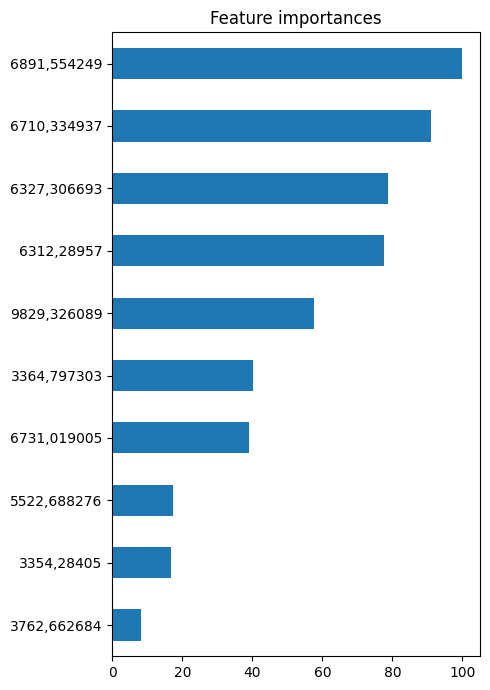

In [ ]:
feature_importances_plot(model=forest10, labels=X.columns)

In [ ]:
forest10.oob_score_

0.964885207618234

In [ ]:
y_pred = forest10.predict(X_test)

In [ ]:
r2_rf10 = r2_score(y_test, y_pred)
print('R2 score of random forest classifier on test set: {:.3f}'.format(r2_rf10))

R2 score of random forest classifier on test set: 0.956


In [ ]:
rmse_rf10 = mean_squared_error(y_test, y_pred, squared=False)
print('Mean squared error of random forest classifier on test set: {:.3f}'.format(rmse_rf10))

Mean squared error of random forest classifier on test set: 0.177


In [ ]:
#regression_diagnostic_plot(y_test, y_pred)

TO DO:
- train con tutto dataset (maldi)
- Pca / feature selection
- dataset con 46 colonne maldi
- modello con multitarget (sensibilità agli antibiotici)

### Training con tutte le colonne maldi

In [ ]:
y = maldi['target']
X = maldi.drop(columns='target')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(123, 304)
(123,)
(31, 304)
(31,)


In [ ]:
#Scaling dati
ss = StandardScaler()

In [ ]:
X_train = ss.fit_transform(X=X_train)
X_test = ss.transform(X=X_test)

#### Logistic regression with all maldi

In [ ]:
logr = LogisticRegression()
logr.fit(X=X_train,y=y_train)

LogisticRegression()

In [ ]:
y_pred = logr.predict(X_test)
y_pred

array([2, 1, 2, 0, 2, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 2, 0, 2, 2, 0, 2, 2,
       1, 2, 2, 1, 0, 1, 2, 1, 0], dtype=int64)

In [ ]:
accuracy_logic = logr.score(X_test, y_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(accuracy_logic))

Accuracy of logistic regression classifier on test set: 0.774


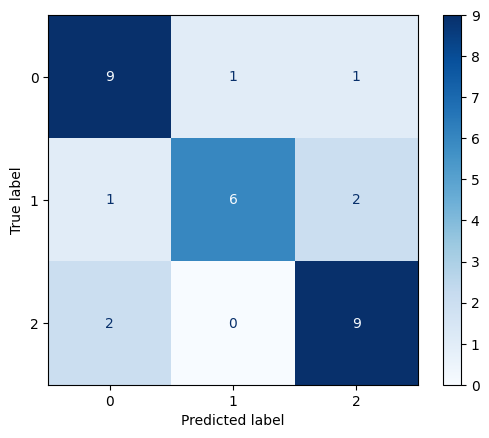

In [ ]:
ConfusionMatrixDisplay.from_estimator(estimator=logr, X=X_test, y=y_test, cmap='Blues')

#### Decision tree with all maldi

In [ ]:
dtc = DecisionTreeClassifier(random_state=42)
dtc = dtc.fit(X=X_train, y=y_train)
dtc

DecisionTreeClassifier(random_state=42)

In [ ]:
dtc.get_depth()

4

In [ ]:
feature_importances = dtc.feature_importances_
feature_index = X.columns
myDict = dict(zip(feature_index, feature_importances))
myDict = dict(sorted(myDict.items(), key=lambda item: item[1], reverse = True))

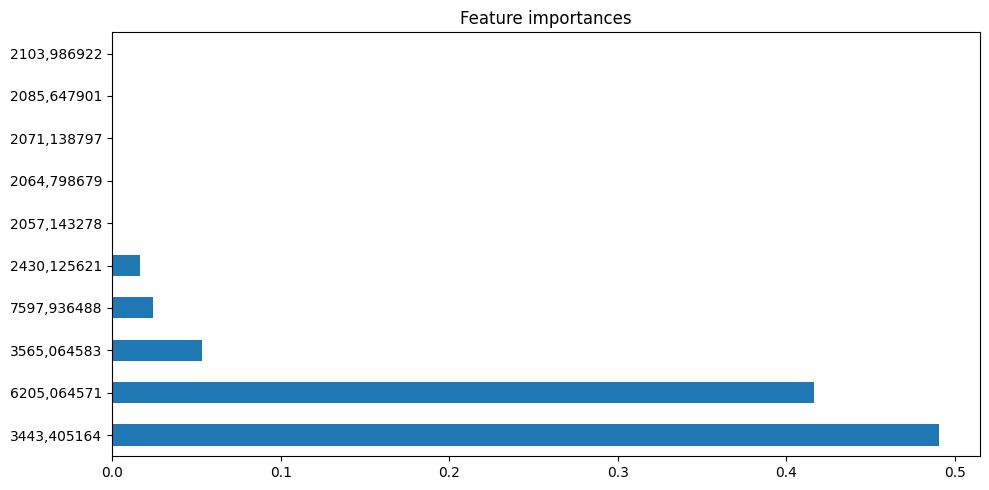

In [ ]:
series = pd.Series(data=myDict.values(), index=myDict.keys()).head(10)
series.plot(kind="barh", figsize=(10, 5), title=f"Feature importances", legend=None)
plt.tight_layout()
plt.show()

In [ ]:
y_pred = dtc.predict(X=X_test)
accuracy_albero = accuracy_score(y_true=y_test, y_pred=y_pred)
print('Accuracy of decision tree classifier on test set: {:.3f}'.format(accuracy_albero))

Accuracy of decision tree classifier on test set: 0.968


In [ ]:
y_pred_train = dtc.predict(X=X_train)
accuracy_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)
print(f"train accuracy score: {accuracy_train:.4f}")

train accuracy score: 1.0000


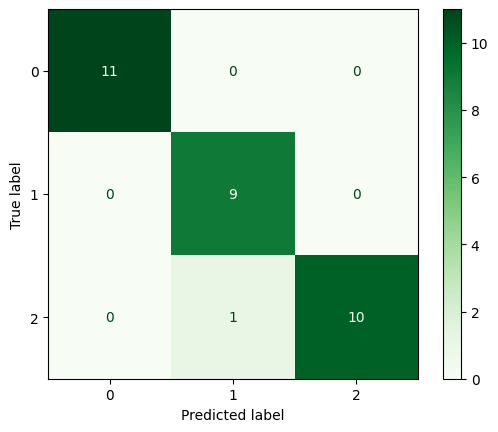

In [ ]:
ConfusionMatrixDisplay.from_estimator(estimator=dtc, X=X_test, y=y_test, cmap='Greens')

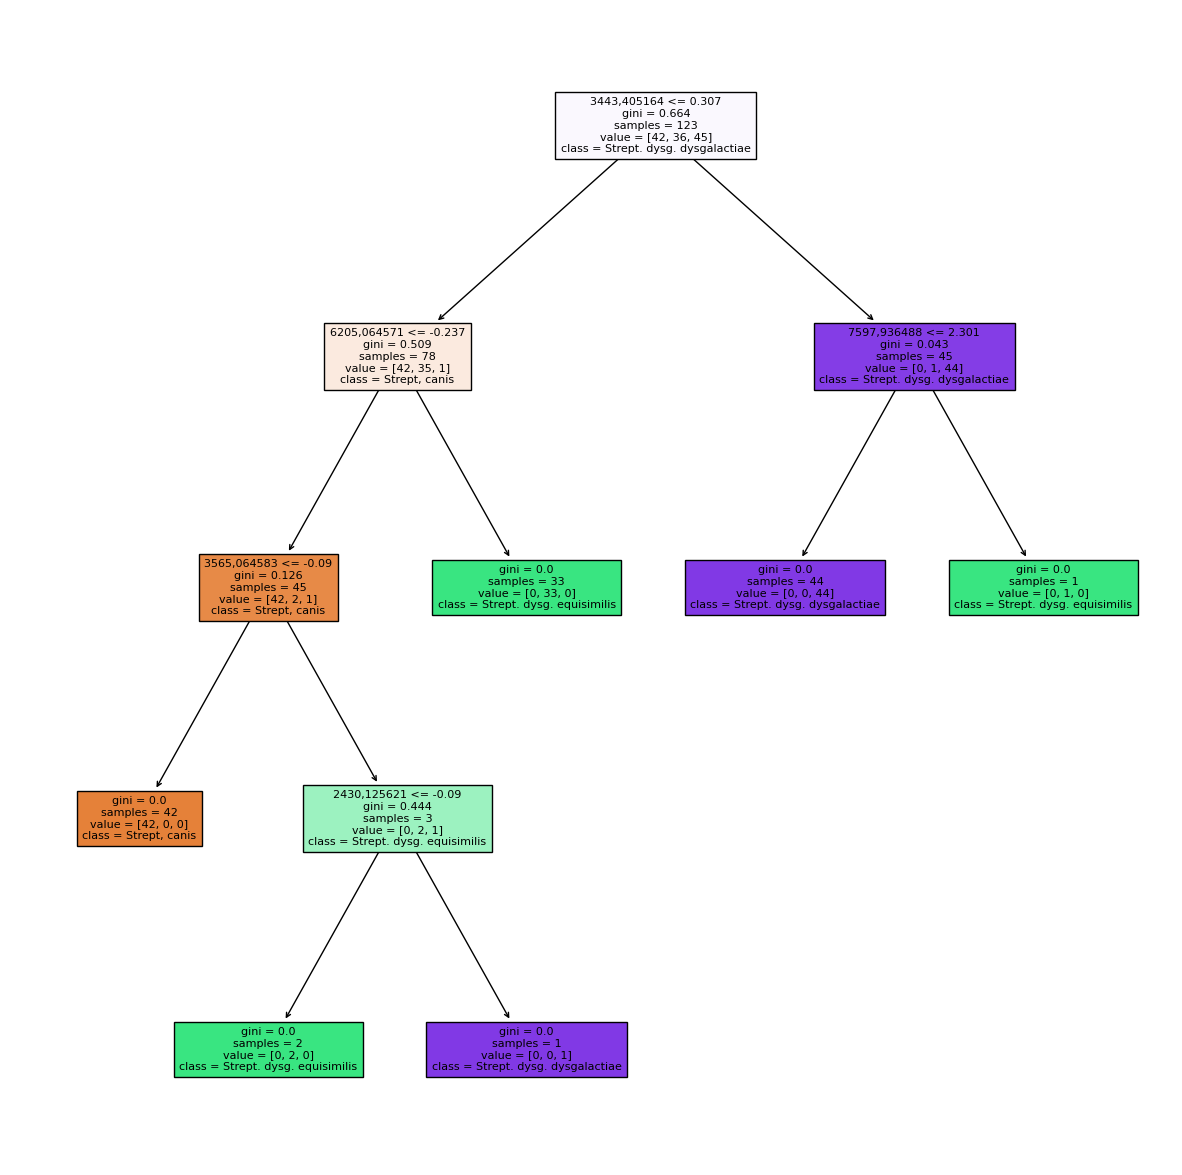

In [ ]:
feature_names = feature_index
class_names = ["Strept, canis","Strept. dysg. equisimilis", "Strept. dysg. dysgalactiae"]

plt.figure(figsize=(15, 15))
plot_tree(decision_tree=dtc, 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, fontsize=8)
plt.show()

#### K-nn with all maldi

In [ ]:
knn_scores = []

for k in range(1, X_train.shape[0], 2):
    # model definition and training
    knn = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=k))
    ])
    knn.fit(X=X_train, y=y_train)
    # compute accuracy on test set
    accuracy = knn.score(X_test, y_test)
    # store the results on a list of dictionaries
    metrics = {"# neighbors": k, "accuracy": accuracy}
    knn_scores.append(metrics)

# convert the list of dictionaries to pandas dataframe
df_knn_scores = pd.DataFrame(data=knn_scores)    #molto facile eveloce da dizionario a dataframe 
df_knn_scores

,# neighbors,accuracy
0,1,0.741935
1,3,0.774194
2,5,0.774194
3,7,0.741935
4,9,0.806452
...,...,...
56,113,0.451613
57,115,0.419355
58,117,0.354839
59,119,0.354839


In [ ]:
mask = df_knn_scores["accuracy"] == df_knn_scores["accuracy"].max()
knn_k = df_knn_scores['accuracy'].idxmax()
n = df_knn_scores['# neighbors'][knn_k]
df_knn_scores[mask]

,# neighbors,accuracy
30,61,0.870968
31,63,0.870968
32,65,0.870968
33,67,0.870968


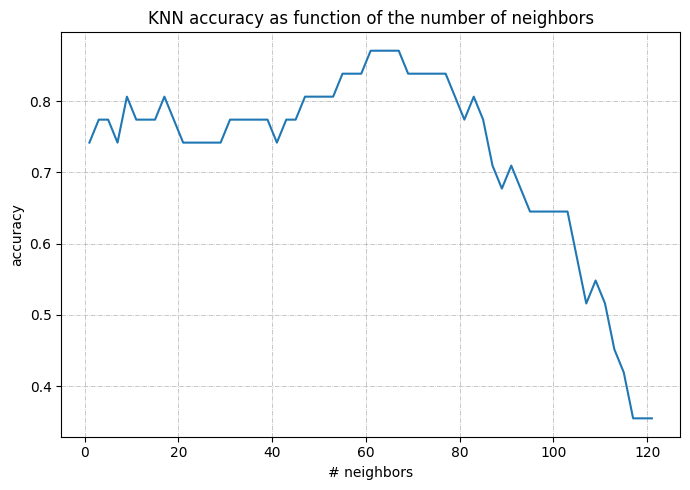

In [ ]:
plt.figure(figsize=(7, 5))
plt.title("KNN accuracy as function of the number of neighbors")
sns.lineplot(x="# neighbors", y="accuracy", data=df_knn_scores)
plt.grid(linestyle='-.', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
knn = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=n))
])
knn.fit(X=X_train, y=y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsClassifier(n_neighbors=61))])

In [ ]:
y_pred = knn.predict(X=X_test)
accuracy_knn = accuracy_score(y_true=y_test, y_pred=y_pred)
print('Accuracy of k-nn classifier on test set with k='+str(n)+': {:.3f}'.format(accuracy_knn))

Accuracy of k-nn classifier on test set with k=61: 0.871


#### Random Forest with all maldi

In [ ]:
forest = RandomForestRegressor(n_estimators=200, 
                               max_features="sqrt", 
                               oob_score=True, 
                               random_state=42) # n_jobs=-1 per multithreading
forest.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=200, oob_score=True,
                      random_state=42)

<font color= "red">Come mostro solo le prime 10?</font>

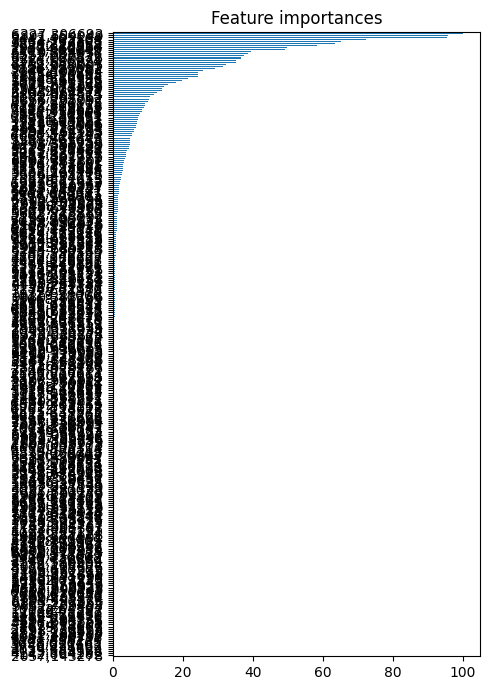

In [ ]:
feature_importances_plot(model=forest, labels=X.columns)

In [ ]:
forest.oob_score_

0.9730077810432438

In [ ]:
y_pred = forest.predict(X_test)

In [ ]:
r2_rf = r2_score(y_test, y_pred)
print('R2 score of random forest classifier on test set: {:.3f}'.format(r2_rf))

R2 score of random forest classifier on test set: 0.977


In [ ]:
rmse_rf = mean_squared_error(y_test, y_pred, squared=False)
print('R2 score of random forest classifier on test set: {:.3f}'.format(rmse_rf))

R2 score of random forest classifier on test set: 0.126


### Training con dimensionality reduction (PCA)

In [ ]:
y = maldi['target']
X = maldi.drop(columns='target')

In [ ]:
pipeline = Pipeline(
    steps=[
        ("Scaler", StandardScaler()),
        ("PCA", PCA(n_components=None))
    ]
)
pipeline


Pipeline(steps=[('Scaler', StandardScaler()), ('PCA', PCA())])

In [ ]:
X_pca = pipeline.fit_transform(X)
X_pca = pd.DataFrame(X_pca)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(123, 154)
(123,)
(31, 154)
(31,)


In [ ]:
#pca.n_components_

In [ ]:
#pca.explained_variance_ratio_

#### Logistic regression with all maldi

In [ ]:
logr_pca = LogisticRegression()
logr_pca.fit(X=X_train,y=y_train)

LogisticRegression()

In [ ]:
y_pred = logr_pca.predict(X_test)
accuracy_logic_pca = logr_pca.score(X_test, y_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(accuracy_logic_pca))

Accuracy of logistic regression classifier on test set: 1.000


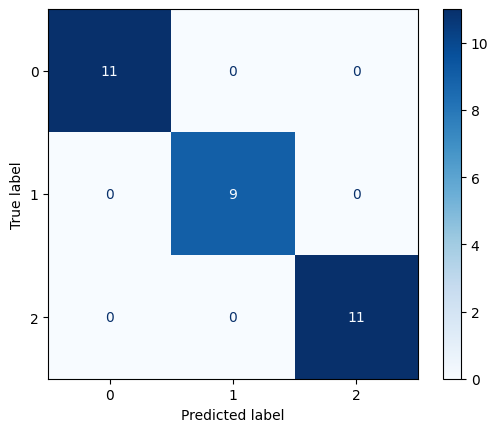

In [ ]:
ConfusionMatrixDisplay.from_estimator(estimator=logr_pca, X=X_test, y=y_test, cmap='Blues')

#### Decision tree with all maldi

In [ ]:
dtc_pca = DecisionTreeClassifier(random_state=42)
dtc_pca = dtc_pca.fit(X=X_train, y=y_train)
dtc_pca

DecisionTreeClassifier(random_state=42)

In [ ]:
dtc_pca.get_depth()

4

In [ ]:
feature_importances = dtc_pca.feature_importances_
feature_index = X_pca.columns
myDict = dict(zip(feature_index, feature_importances))
myDict = dict(sorted(myDict.items(), key=lambda item: item[1], reverse = True))

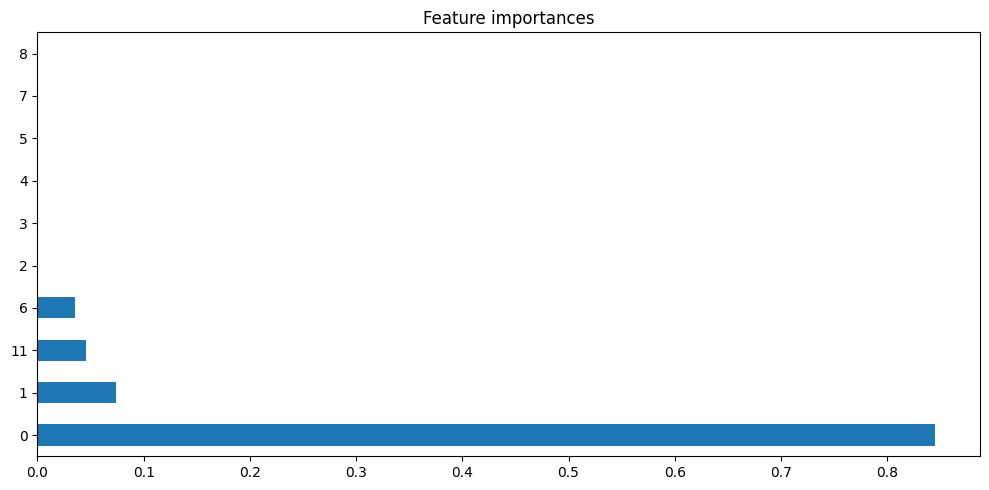

In [ ]:
series = pd.Series(data=myDict.values(), index=myDict.keys()).head(10)
series.plot(kind="barh", figsize=(10, 5), title=f"Feature importances", legend=None)
plt.tight_layout()
plt.show()

In [ ]:
y_pred = dtc_pca.predict(X=X_test)
accuracy_albero_pca = accuracy_score(y_true=y_test, y_pred=y_pred)
print('Accuracy of decision tree classifier on test set: {:.3f}'.format(accuracy_albero_pca))

Accuracy of decision tree classifier on test set: 1.000


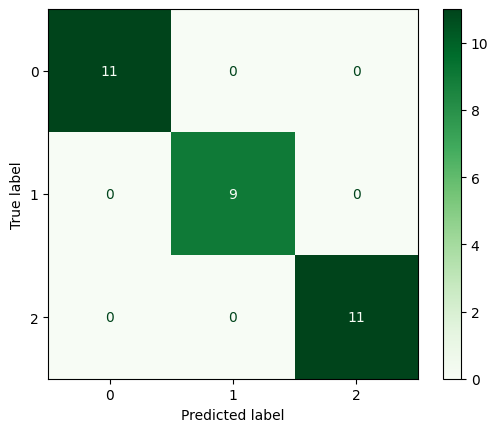

In [ ]:
ConfusionMatrixDisplay.from_estimator(estimator=dtc_pca, X=X_test, y=y_test, cmap='Greens')

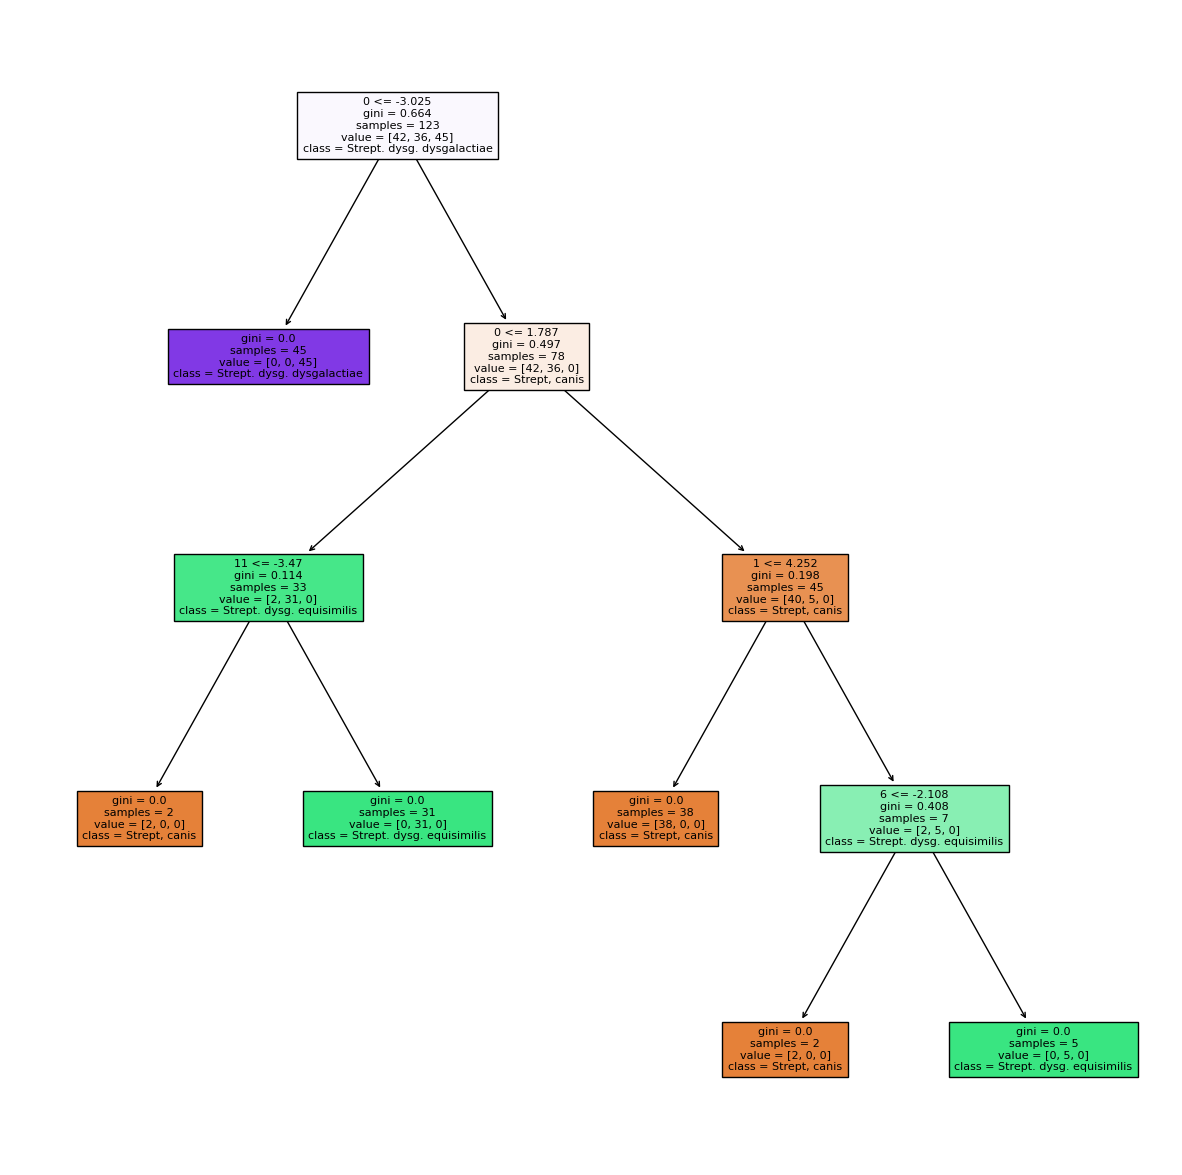

In [ ]:
feature_names = feature_index
class_names = ["Strept, canis","Strept. dysg. equisimilis", "Strept. dysg. dysgalactiae"]

plt.figure(figsize=(15, 15))
plot_tree(decision_tree=dtc_pca, 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, fontsize=8)
plt.show()

#### K-nn with all maldi

In [ ]:
knn_scores = []

for k in range(1, X_train.shape[0], 2):
    # model definition and training
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X=X_train, y=y_train)
    # compute accuracy on test set
    accuracy = knn.score(X_test, y_test)
    # store the results on a list of dictionaries
    metrics = {"# neighbors": k, "accuracy": accuracy}
    knn_scores.append(metrics)

# convert the list of dictionaries to pandas dataframe
df_knn_scores_pca = pd.DataFrame(data=knn_scores)    #molto facile eveloce da dizionario a dataframe 
df_knn_scores_pca

,# neighbors,accuracy
0,1,0.967742
1,3,0.967742
2,5,1.000000
3,7,1.000000
4,9,1.000000
...,...,...
56,113,0.483871
57,115,0.387097
58,117,0.354839
59,119,0.354839


In [ ]:
mask = df_knn_scores_pca["accuracy"] == df_knn_scores_pca["accuracy"].max()   
knn_k = df_knn_scores_pca["accuracy"].idxmax()
n = df_knn_scores['# neighbors'][knn_k]
df_knn_scores_pca[mask]

,# neighbors,accuracy
2,5,1.0
3,7,1.0
4,9,1.0
5,11,1.0
6,13,1.0
7,15,1.0


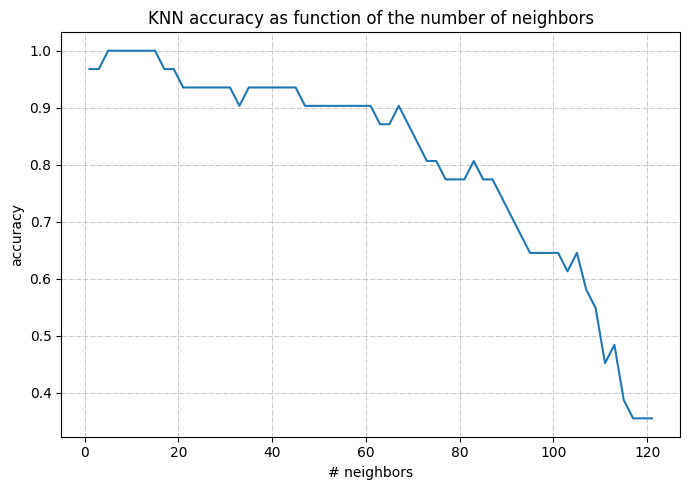

In [ ]:
plt.figure(figsize=(7, 5))
plt.title("KNN accuracy as function of the number of neighbors")
sns.lineplot(x="# neighbors", y="accuracy", data=df_knn_scores_pca)
plt.grid(linestyle='-.', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
knn_pca = KNeighborsClassifier(n_neighbors=n)
knn_pca.fit(X=X_train, y=y_train)

KNeighborsClassifier()

In [ ]:
y_pred = knn_pca.predict(X=X_test)
accuracy_knn_pca = accuracy_score(y_true=y_test, y_pred=y_pred)
print('Accuracy of k-nn classifier on test set: {:.3f}'.format(accuracy_knn_pca))

Accuracy of k-nn classifier on test set: 1.000


#### Random Forest with all maldi

In [ ]:
forest_pca = RandomForestRegressor(n_estimators=200, 
                               max_features="sqrt", 
                               oob_score=True, 
                               random_state=42) # n_jobs=-1 per multithreading
forest_pca.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=200, oob_score=True,
                      random_state=42)

<font color= "red">Come mostro solo le prime 10?</font>

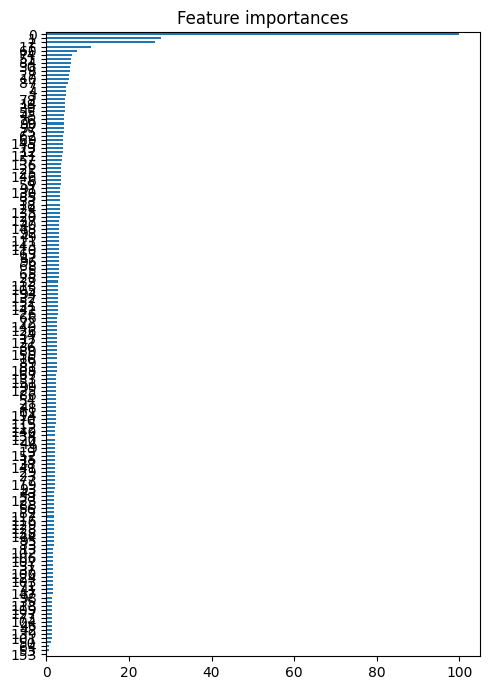

In [ ]:
feature_importances_plot(model=forest_pca, labels=X_pca.columns)

In [ ]:
forest_pca.oob_score_

0.3645077744951648

In [ ]:
y_pred = forest_pca.predict(X_test)

In [ ]:
r2_rf = r2_score(y_test, y_pred)
print('R2 score of random forest classifier with PCA on test set: {:.3f}'.format(r2_rf))

R2 score of random forest classifier with PCA on test set: 0.433


In [ ]:
rmse_rf = mean_squared_error(y_test, y_pred, squared=False)
print('R2 score of random forest classifier with PCA on test set: {:.3f}'.format(rmse_rf))

R2 score of random forest classifier with PCA on test set: 0.634


# Antibiotici

In [ ]:
antibiotici

,Eritromicina,Ceftiofur,Tetraciclina,Gentamicina,Penicillina,Ampicillina,Sulfametossazolo_trimethoprim,Clindamicina,Enrofloxacin
ID Strain,,,,,,,,,
V13,NS,S,NS,NS,S,S,S,S,NS
V142,NS,S,S,S,S,S,S,S,NS
V151,S,S,S,NS,S,S,S,S,NS
V160,S,S,NS,NS,S,S,S,S,NS
V161,S,S,S,NS,S,S,S,S,NS
...,...,...,...,...,...,...,...,...,...
V800,S,S,NS,S,S,S,S,S,NS
V82,S,S,S,NS,S,S,S,S,S
V90,S,S,NS,NS,S,S,S,S,NS


In [ ]:
antibiotici.dtypes

Eritromicina                     object
Ceftiofur                        object
Tetraciclina                     object
Gentamicina                      object
Penicillina                      object
Ampicillina                      object
Sulfametossazolo_trimethoprim    object
Clindamicina                     object
Enrofloxacin                     object
dtype: object

In [ ]:
i = 0
for column in antibiotici.columns:
    print(i, column, antibiotici[column].unique())
    i += 1

0 Eritromicina ['NS' 'S']
1 Ceftiofur ['S']
2 Tetraciclina ['NS' 'S']
3 Gentamicina ['NS' 'S']
4 Penicillina ['S']
5 Ampicillina ['S']
6 Sulfametossazolo_trimethoprim ['S' 'NS']
7 Clindamicina ['S' 'NS']
8 Enrofloxacin ['NS' 'S']


Ceftiofur, Penicillina, Ampicillina   ['S'] --> 1 solo valore -> si possono eliminare
Tetraciclina, Gentamicina, Sulfametossazolo_trimethoprim, Clindamicina ['S' 'NS'] --> OneHotEncoder

In [ ]:
antibiotici.drop(['Ceftiofur', 'Penicillina', 'Ampicillina'], axis=1, inplace=True)
antibiotici_X = ['Tetraciclina', 'Gentamicina', 'Sulfametossazolo_trimethoprim', 'Clindamicina','Enrofloxacin']
ct_ant = ColumnTransformer(transformers=[
    ("OneHot", OneHotEncoder(drop="first", sparse=False, dtype=int), antibiotici_X)
],remainder="passthrough")

antibiotici_arr = ct_ant.fit_transform(X=antibiotici[antibiotici_X])
antibiotici_enc = pd.DataFrame(data=antibiotici_arr, columns=ct_ant.get_feature_names_out())
antibiotici_enc

,OneHot__Tetraciclina_S,OneHot__Gentamicina_S,OneHot__Sulfametossazolo_trimethoprim_S,OneHot__Clindamicina_S,OneHot__Enrofloxacin_S
0,0,0,1,1,0
1,1,1,1,1,0
2,1,0,1,1,0
3,0,0,1,1,0
4,1,0,1,1,0
...,...,...,...,...,...
149,0,1,1,1,0
150,1,0,1,1,1
151,0,0,1,1,0
152,1,0,1,1,0


In [ ]:
antibiotici[antibiotici_X] = antibiotici_enc.values
antibiotici

,Eritromicina,Tetraciclina,Gentamicina,Sulfametossazolo_trimethoprim,Clindamicina,Enrofloxacin
ID Strain,,,,,,
V13,NS,0,0,1,1,0
V142,NS,1,1,1,1,0
V151,S,1,0,1,1,0
V160,S,0,0,1,1,0
V161,S,1,0,1,1,0
...,...,...,...,...,...,...
V800,S,0,1,1,1,0
V82,S,1,0,1,1,1
V90,S,0,0,1,1,0


# Geni Antibiotico

In [ ]:
geni_antibiotico

,aad(6),ANT(6)-Ia,APH(2'')-IIIa,APH(3')-IIIa,catS,dfrF,E. faecalis chloramphenicol acetyltransferase,Erm(47),ErmB,fexA,...,poxtA,SAT-4,tet(40),tet(L),tetM,tetO,tetS,tetT,vatE,fbp54
ID Strain,,,,,,,,,,,,,,,,,,,,,
V13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
V142,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
V151,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
V160,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
V161,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
V82,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
V90,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
geni_antibiotico.dtypes

aad(6)                                           int64
ANT(6)-Ia                                        int64
APH(2'')-IIIa                                    int64
APH(3')-IIIa                                     int64
catS                                             int64
dfrF                                             int64
E. faecalis chloramphenicol acetyltransferase    int64
Erm(47)                                          int64
ErmB                                             int64
fexA                                             int64
L._reuteri cat-TC                                int64
lmrP                                             int64
lnuC                                             int64
lnuD                                             int64
lsaC                                             int64
lsaE                                             int64
mefE                                             int64
optrA                                            int64
poxtA     

# Virulenza

In [ ]:
virulenza

,gbs0630,gbs0631,gbs0632,hasC,lmb,mf2,mf3,scpA,sda,ska,slo,smeZ,spec,speg,spek,spel,spem
ID Strain,,,,,,,,,,,,,,,,,
V13,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
V142,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
V151,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
V160,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
V161,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
V82,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
V90,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
virulenza.columns

Index(['gbs0630', 'gbs0631', 'gbs0632', 'hasC', 'lmb', 'mf2', 'mf3', 'scpA',
       'sda', 'ska', 'slo', 'smeZ', 'spec', 'speg', 'spek', 'spel', 'spem'],
      dtype='object')